# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Curación (TP2)

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---

## Librerías

In [178]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones propias
from utils_limpieza import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [2]:
# Cargar datos
path = '../data/raw/tp2_muestra_diplodatos_ventas_omega_modelo_2023.csv'
ventas = pd.read_csv(path)


C:\Users\Patricio\AppData\Local\Temp\ipykernel_4056\3921706967.py:3: DtypeWarning: Columns (10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ventas = pd.read_csv(path)


---
# Preprocesamiento

## Limpieza sugerida al principio del TP2 <span style="color:magenta">**(Pasos 1 y 2)**</span>
- [x] Eliminar las variables en `cols_dropear`.
- [x] Renombrar a 'Otros' las subcategorías que no tengan `MODELO`.
- [x] Se eliminan los registros en 'Otros'. Previamente se almacenan en un dataset aparte.

In [3]:
print(f'El df original tiene {ventas.shape[0]} registros y {ventas.shape[1]} variables.\n')

# Paso 1
cols_dropear = ['INSCRIPCION', 'CATEGORIA', 'DESCRIPCION_CATEGORIA', 'CATEGORIA (Ajustado)', 'NOMBRE']
ventas_renamed = limpiar_basic(ventas, cols_drop=cols_dropear)
print(f'Luego del paso 1 se tiran {len(cols_dropear)} variables, quedando {ventas_renamed.shape[1]} variables.\n')

# Paso 2
ventas_renamed = renombrar_elementos(ventas_renamed, 
                                     columna='SUB-CATEGORIA', 
                                     fill_otros='Otros')

scu_vr = ventas_renamed['SUB-CATEGORIA'].nunique()
scu_ot = ventas['SUB-CATEGORIA'].nunique() - scu_vr + 1
print(f'Luego del paso 2 quedan {scu_vr} subcategorías únicas.')
print(f'\tLas {scu_ot} subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".')
reg_ot = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] == 'Otros'].shape[0]
print(f'\t\t"Otros" cuenta con {reg_ot} registros >> {100*reg_ot/ventas.shape[0]:.2f}% del dataset original')
print(f'\nLas {scu_vr-1} subcategorías que sí tienen vendedores modelo son:')

ventas_renamed.groupby(by=['SUB-CATEGORIA'])['MODELO'].sum().sort_values(ascending=False)[:12]

El df original tiene 435489 registros y 19 variables.

Luego del paso 1 se tiran 5 variables, quedando 14 variables.

Luego del paso 2 quedan 13 subcategorías únicas.
	Las 9 subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".
		"Otros" cuenta con 56781 registros >> 13.04% del dataset original

Las 12 subcategorías que sí tienen vendedores modelo son:


SUB-CATEGORIA
Venta de Artículos, productos, accesorios, etc de diversos materiales      1902
Venta de Combustibles (Incluye tmb gas, carbón, leña, etc)                  951
Venta de Productos Alimenticios, Bebidas, Lácteos y afines                  586
Venta de Productos farmacéuticos, de perfumería, cosméticos y similares     420
Venta de Combustibles Ley 23966 (Incluye tmb gas, carbón, leña, etc)        394
Venta en Comisión, Consignación o Intermediación de Productos Varios        336
Cigarrillos, tabacos y afines                                               282
Supermercados, Hipermercados, Kioscos y afines                              156
Venta de Combustibles para reventa (Incluye tmb gas, carbón, leña, etc)     131
Venta de Autos, Camionetas, Motos, y Afines                                 126
Venta de Semillas, Fertilizantes, Granos y afines                            84
Instalación, Mantenimiento, Reparación, etc de productos varios               6
Name: MODELO, dtype: int64

In [4]:
#Eliminación de registros en "Otros" y almacenamiento en un dataset aparte
ventas_otros = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] == 'Otros'].copy()
ventas_otros.to_csv('../data/interim/tp2_ventas_otros.csv', index=False)

ventas_renamed = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] != 'Otros'].copy()
print(ventas_renamed.shape)

(378708, 14)


## Simplificación de variables temporales <span style="color:magenta">**(Paso 6)**</span>
Creamos la variable `Fecha`, que surge como:
    $$Fecha = Año + Mes$$

Luego vamos a optar por droppear `Mes` y `Año`. Aunque para el análisis temporal habrá momentos en que necesitamos tener `Año` y `Mes` por separado, son fácilmente recuperables a través de `Fecha`.

In [5]:
ventas_renamed["Fecha"] = pd.to_datetime(ventas_renamed['MES'].astype(str) + '-' + ventas_renamed['AÑO'].astype(str), format='%m-%Y')
cols_dropear = ['MES', 'AÑO']
ventas_renamed = limpiar_basic(ventas_renamed, cols_drop=cols_dropear)

ventas_renamed[:3]

,ID_VENDEDOR,DEPOSITO,TOTAL_VENTAS,PORCENTAJE_COMISION_EMPRESA,COMISION_EMPRESA,TRATAMIENTO_FISCAL,DESC_TRATAMIENTO_FISCAL,TRATAMIENTO_DIFERNCIAL,CM04,SUB-CATEGORIA,OMEGA,MODELO,Fecha
0,20246151459,469090,14622.16,0.028,409.42,0.0,Normal,NaN,NaN,"Venta de Artículos, productos, accesorios, etc...",1,0,2019-01-01
1,30698521747,464129,62477.00,0.040,2499.08,0.0,Normal,NaN,NaN,"Venta de Artículos, productos, accesorios, etc...",1,0,2019-01-01
2,30698521747,475190,3373941.00,0.040,134957.64,0.0,Normal,NaN,NaN,"Venta de Artículos, productos, accesorios, etc...",1,0,2019-01-01


## Detección de datos faltantes
- [x] Chequear presencia de datos faltantes
- [x] Analizar su correlación

Faltan datos en las mismas variables que antes.

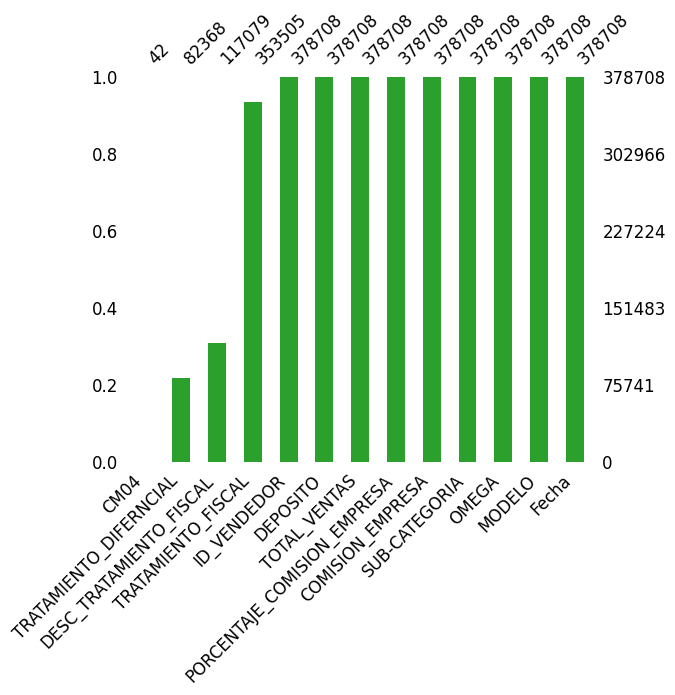

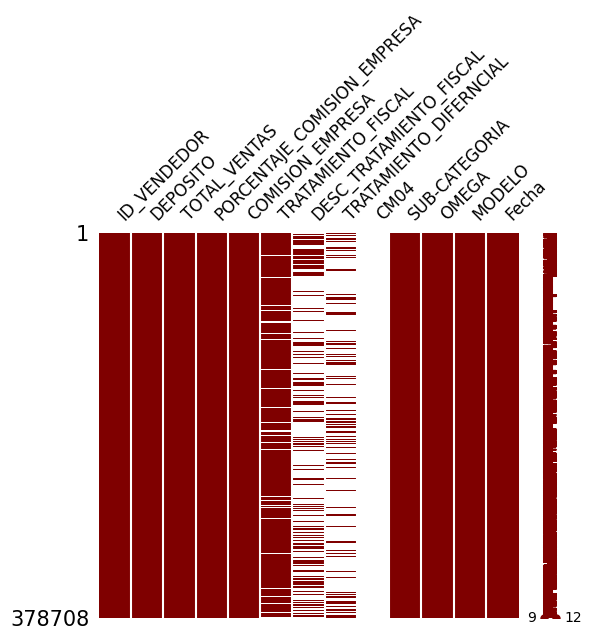

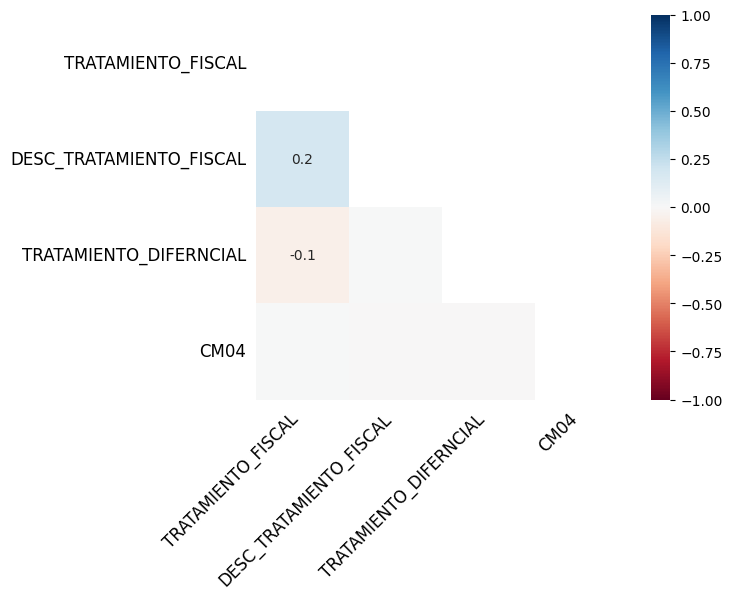

In [6]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

## Relación entre variables fiscales <span style="color:magenta">**(Paso 5)**</span>

In [7]:
ventas_fiscal = ventas_renamed[['TRATAMIENTO_FISCAL', 'DESC_TRATAMIENTO_FISCAL', 'TRATAMIENTO_DIFERNCIAL']].copy()

In [8]:
ventas_fiscal['TRATAMIENTO_FISCAL'] = ventas_fiscal['TRATAMIENTO_FISCAL'].fillna('Waring: Relleno')
ventas_fiscal['DESC_TRATAMIENTO_FISCAL'] = ventas_fiscal['DESC_TRATAMIENTO_FISCAL'].fillna('Waring: Relleno')
ventas_fiscal['TRATAMIENTO_DIFERNCIAL'] = ventas_fiscal['TRATAMIENTO_DIFERNCIAL'].fillna('Waring: Relleno')

### `TRATAMIENTO_FISCAL` vs `DESC_TRATAMIENTO_FISCAL`

Queremos chequear para qué valores de `TRATAMIENTO_FISCAL` aparecen valores de `DESC_TRATAMIENTO_FISCAL`.

In [9]:
pd.crosstab(ventas_fiscal['TRATAMIENTO_FISCAL'], ventas_fiscal['DESC_TRATAMIENTO_FISCAL'], dropna=False)

DESC_TRATAMIENTO_FISCAL,Exento/Desgravado,Minorista,Normal,Otro Tratamiento Fiscal,Waring: Relleno
TRATAMIENTO_FISCAL,,,,,
0.0,0,0,28259,0,0
1.0,182,0,0,0,0
2.0,0,1,0,0,0
3.0,0,0,0,1728,0
0,0,0,81899,0,0
1,587,0,0,0,0
3,0,0,0,4423,0
Alícuota agravada,0,0,0,0,76566
Alícuota reducida,0,0,0,0,913


Al analizar la tabla de contingencia, vemos que los valores de `DESC_TRATAMIENTO_FISCAL` sólo aparecen cuando `TRATAMIENTO_FISCAL` asume valores 0, 1, 2 ó 3. 
A su vez, hay correspondencia entre 0 y Norm, 1 y Exento, 2 y Min, 3 y Otro. 
¿Se puede unificar todo como `TRATAMIENTO_FISCAL`, eliminando entonces `DESC_TRATAMIENTO_FISCAL`? ¿Tiene sentido que falte la descripción asociada al tratamiento?

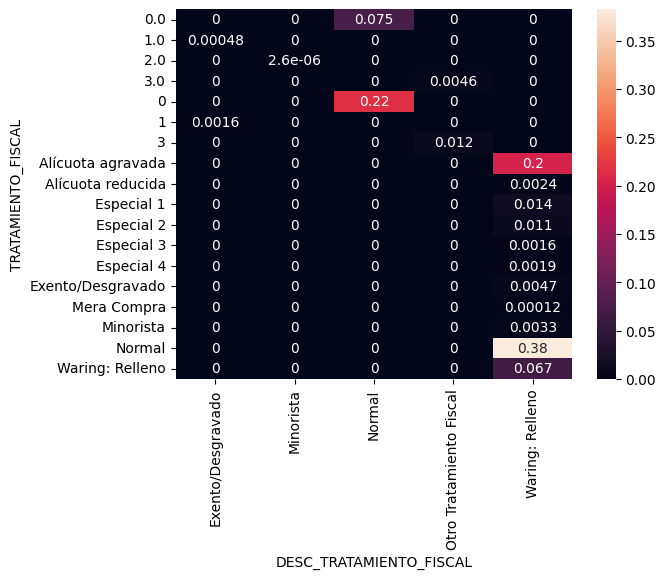

In [10]:
vad = pd.crosstab(ventas_fiscal['TRATAMIENTO_FISCAL'], ventas_fiscal['DESC_TRATAMIENTO_FISCAL'], normalize=True)
sns.heatmap(vad, annot=True)

plt.show()

Vemos que sí existe una gran correlación entre "Norm" de `DESC_TRATAMIENTO_FISCAL` y "0" de `TRATAMIENTO_FISCAL`.

### `TRATAMIENTO_FISCAL` vs `TRATAMIENTO_DIFERNCIAL`

Ahora veamos para qué valores de `TRATAMIENTO_FISCAL` aparecen valores de `TRATAMIENTO_DIFERNCIAL`. Al analizar la tabla de contingencia vemos que no hay un patrón claro. Podríamos tomar a un dato faltante como "sin tratamiento especial".

In [11]:
pd.crosstab(ventas_fiscal['TRATAMIENTO_FISCAL'], ventas_fiscal['TRATAMIENTO_DIFERNCIAL'], dropna=False)

TRATAMIENTO_DIFERNCIAL,Artículo 16,Artículo 17,Artículo 18,Artículo 19,Artículo 19 y 20,Artículo 20,Artículo 21,Artículo 22,Artículo 28,Artículo 31,Artículo 34,Waring: Relleno
TRATAMIENTO_FISCAL,,,,,,,,,,,,
0.0,173,261,1193,459,2322,0,436,0,161,704,0,22550
1.0,0,0,15,45,0,0,0,0,0,1,0,121
2.0,0,0,0,0,0,0,0,0,0,0,0,1
3.0,0,117,24,29,1039,0,363,0,0,2,0,154
0,640,5,57,661,112,3136,7253,412,6,22,1948,67647
1,0,0,0,3,0,14,162,0,0,0,2,406
3,0,2,1,531,39,80,2857,731,0,0,1,181
Alícuota agravada,608,12,181,62,81,2706,1770,1025,0,56,667,69398
Alícuota reducida,249,0,17,0,9,36,75,1,0,0,36,490


*   Se concluye que la variable que más información aporta es la de `TRATAMIENTO_FISCAL`, superando a `DESC_TRATAMIENTO_FISCAL` en que tiene menos valores perdidos. Y a su vez, la información de `DESC_TRATAMIENTO_FISCAL` (Exento, Min, Norm, Otro), es capturada por los valores 1, 2, 0, 3 de `TRATAMIENTO_FISCAL`, respectivamente.
*   Respecto a `TRATAMIENTO_DIFERNCIAL`, la misma es superada por `TRATAMIENTO_FISCAL` en cuanto a ausencia de valores perdidos. La variable `TRATAMIENTO_FISCAL`, en el práctico anterior, había permitido detectar ciertas tendencias de ventas. A su vez que no queda claro el aporte de `TRATAMIENTO_DIFERNCIAL`.

La decisión es droppear `DESC_TRATAMIENTO_FISCAL` y `TRATAMIENTO_DIFERNCIAL`.

In [12]:
ventas_renamed = limpiar_basic(ventas_renamed, ['DESC_TRATAMIENTO_FISCAL', 'TRATAMIENTO_DIFERNCIAL'])

## Variable `CM04` <span style="color:magenta">**(Paso 4)**</span>

In [13]:
checkear_unicidad(ventas_renamed, 'CM04', 'ID_VENDEDOR')

Para cada ID_VENDEDOR solo existe un valor de CM04.


In [14]:
ventas_CM = ventas_renamed[ventas_renamed['CM04'] == 'Si'].copy()
ventas_CM.describe().T#['ID_VENDEDOR'].value_counts()

,count,mean,min,25%,50%,75%,max,std
ID_VENDEDOR,42.0,30698987940.0,30698987940.0,30698987940.0,30698987940.0,30698987940.0,30698987940.0,0.0
DEPOSITO,42.0,475410.0,475410.0,475410.0,475410.0,475410.0,475410.0,0.0
TOTAL_VENTAS,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PORCENTAJE_COMISION_EMPRESA,42.0,3.964286,0.0,4.0,4.75,4.75,4.75,1.658838
COMISION_EMPRESA,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OMEGA,42.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
MODELO,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fecha,42,2020-09-15 09:42:51.428571392,2019-01-01 00:00:00,2019-11-08 12:00:00,2020-09-16 00:00:00,2021-07-24 06:00:00,2022-06-01 00:00:00,NaN


Solo hay un caso que está bajo CM igual a 1 (y no es vendedor modelo). El tamaño de muestra equivale al 0,01% de los casos.

In [15]:
print(f"{round(len(ventas_renamed[ventas_renamed['CM04'] == 'Si']) / len(ventas_renamed) * 100, 2)}%")

0.01%


Se procederá a descartar el caso en un dataset aparte y se eliminará la variable `CM04`.

In [16]:
ventas_cm = ventas_renamed[ventas_renamed['CM04'] == 'Si'].copy()
ventas_cm.to_csv('../data/interim/tp2_ventas_cm.csv', index=False)

ventas_renamed = ventas_renamed[ventas_renamed['CM04'] != 'Si'].copy()
ventas_renamed = limpiar_basic(ventas_renamed, 'CM04')

## Anonimizado  <span style="color:magenta">**(Paso 3)**</span>
- [x] Anonimizamos la variable sensible `ID_VENDEDOR`.
- [x] Guardamos esto en un diccionario.

In [17]:
# Anonimizamos y guardamos el diccionario para no perder esta info
ventas_hash, dict_id = anonimizar(ventas_renamed, 'ID_VENDEDOR')

with open("../references/tp2_ID_dict.json", "w") as fp:
    json.dump(dict_id, fp)

print('¡Diccionario generado!')

Actualizando variable ID_VENDEDOR
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%
¡Diccionario generado!


## Simplificación del nombre de las variables
- [x] Simplificamos el nombre de las variables.

In [18]:
# Renombramos
with open("../references/tp2_column_dict.json") as column_dict_json:
    column_dict = json.load(column_dict_json)

ventas_hash.rename(columns = column_dict, inplace = True)
ventas_hash.columns

Index(['ID', 'Deposito', 'Ventas', 'Alicuota', 'Comision', 'Trat_Fisc',
       'Subrubro', 'Omega', 'Modelo', 'Fecha'],
      dtype='object')

## Simplificación de valores posibles en ciertas variables
- [x] Simplificamos de valores en `Deposito`
- [x] Unificación y simplificación de categorías de `Trat_Fisc`.
- [x] Simplificación de categorías en `Subrubro`.
- [x] Guardamos todos estos diccionarios.

In [19]:
# Mapeo de `Deposito` a enteros
ventas_hash, dict_dep = anonimizar(ventas_hash, 'Deposito')

with open("../references/tp2_deposito_dict.json", "w") as fp:
    json.dump(dict_dep, fp)

print('¡Diccionario generado!')

Actualizando variable Deposito
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%
¡Diccionario generado!


In [20]:
# Unificacón y simplificación de categorías de `TRATAMIENTO_FISCAL`
with open("../references/tp1_trat_fisc_dict.json") as trat_fisc_dict_json:
    trat_fisc_dict = json.load(trat_fisc_dict_json)
    
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].astype(str)
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].replace(trat_fisc_dict)

In [21]:
# Simplificación de categorías de `Subrubro`
with open("../references/tp2_subrubro_dict.json") as subrubro_dict_json:
    subrubro_dict = json.load(subrubro_dict_json)

ventas_hash['Subrubro'] = ventas_hash['Subrubro'].replace(subrubro_dict)

In [22]:
ventas_hash['Subrubro'].unique()

array(['Miscelaneo', 'Venta Agrop.', 'Gondola', 'Supermercados', 'Comb.',
       'Farmacia', 'Mantenimiento', 'Com. Varios', 'Vehiculos',
       'Comb. Ley', 'Tabaco', 'Comb. Reventa'], dtype=object)

## Guardado parcial
Guardamos el dataset con las trasnformaciones realizadas hasta el momento, antes de eliminar el efecto de la inflación.

In [23]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_hash.to_csv('../data/interim/tp2_ventas_hash.csv', index=False)

## Eliminación del efecto inflación
Las variables expresadas en pesos aumentan mes a mes por efecto de la inflación. Lo que impide comparar un valor monetario de un mes contra el del mes siguiente. A fin de eliminar este efecto, una alternativa es reexpresar los valores monetarios respecto a un mes base. Por ejemplo, el último mes de la serie.

In [24]:
if 'ventas_hash' not in locals():
    # Para que las funciones se actualicen sin tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_hash = pd.read_csv('../data/interim/tp2_ventas_hash.csv')

ventas_ipc = ventas_hash.copy()
ventas_ipc["Fecha"] = pd.to_datetime(ventas_ipc["Fecha"])

In [25]:
# Obtener el último mes
fecha = ventas_ipc['Fecha'].max()
print(f"El último mes de la serie es el {fecha.month} de {fecha.year}")

El último mes de la serie es el 6 de 2022


El procedimiento es el siguiente:
    $$\text{VAR}_{mm-aaaa} \frac{\text{IPC}_{06-2022}}{\text{IPC}_{mm-aaaa}}$$

Para todo valor de cada variable (VAR) correspondiente a cierto mes "mm-aaaa" se lo divide por el Índice de Precios al Consumidor (IPC) correspondiente a ese mes "mm-aaaa" y luego se lo multiplica por el IPC correspondiente al mes "06-2022".

De esta forma, todos los valores de cada variable VAR van a quedar expresados en unidades monetarias del "06-2022".



Es necesario obtener de manera externa una serie del IPC que publica Indec.

In [26]:
precios_path = "../data/external/tp2_IPC_Indec.csv"

if exists(precios_path):
    print('Este archivo ya existe.')
else:
    print('Este archivo no existe: ¡Vamos a crearlo!')
    url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_23.xls"
    df = pd.read_excel(url, sheet_name="Índices IPC Cobertura Nacional", header=None, usecols="B:CA", skiprows=[0, 1, 2, 3, 4, 6, 7, 8], nrows=2)
    df = df.transpose()
    df.columns = ["Fecha", "INDICE"]
    df["Fecha"] = pd.to_datetime(df["Fecha"])
    df.to_csv(precios_path, index=False)

Este archivo no existe: ¡Vamos a crearlo!


In [27]:
# Abrir dataset de precios
precios = pd.read_csv(precios_path)
precios.head()

,Fecha,INDICE
0,2016-12-01,100.0000
1,2017-01-01,101.5859
2,2017-02-01,103.6859
3,2017-03-01,106.1476
4,2017-04-01,108.9667


Luego debemos unir ambas bases de datos (ventas y precios), de acuerdo a la variable clave `Fecha`

In [28]:
print(ventas_ipc["Fecha"].dtype)
print(precios["Fecha"].dtype)

datetime64[ns]
object


In [29]:
# Hay que asegurar que la variable clave tenga el mismo tipo en los dos dataframes
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

In [30]:
print(ventas_ipc["Fecha"].dtype)
print(precios["Fecha"].dtype)

datetime64[ns]
datetime64[ns]


In [31]:
ventas_ipc = ventas_ipc.merge(precios[["Fecha", "INDICE"]], on="Fecha", how="left")
ventas_ipc.head(3)

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Subrubro,Omega,Modelo,Fecha,INDICE
0,0,0,14622.16,0.028,409.42,0,Miscelaneo,1,0,2019-01-01,189.6101
1,1,1,62477.00,0.040,2499.08,0,Miscelaneo,1,0,2019-01-01,189.6101
2,1,2,3373941.00,0.040,134957.64,0,Miscelaneo,1,0,2019-01-01,189.6101


La series que están expresadas en pesos son las siguientes: 
   * `Ventas`
   * `Comision`

In [32]:
ventas_ipc.head()

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Subrubro,Omega,Modelo,Fecha,INDICE
0,0,0,14622.16,0.028,409.42,0,Miscelaneo,1,0,2019-01-01,189.6101
1,1,1,62477.00,0.040,2499.08,0,Miscelaneo,1,0,2019-01-01,189.6101
2,1,2,3373941.00,0.040,134957.64,0,Miscelaneo,1,0,2019-01-01,189.6101
3,1,3,332660.00,0.040,13306.40,0,Miscelaneo,1,0,2019-01-01,189.6101
4,2,0,695685.00,0.040,27827.40,0,Miscelaneo,1,0,2019-01-01,189.6101


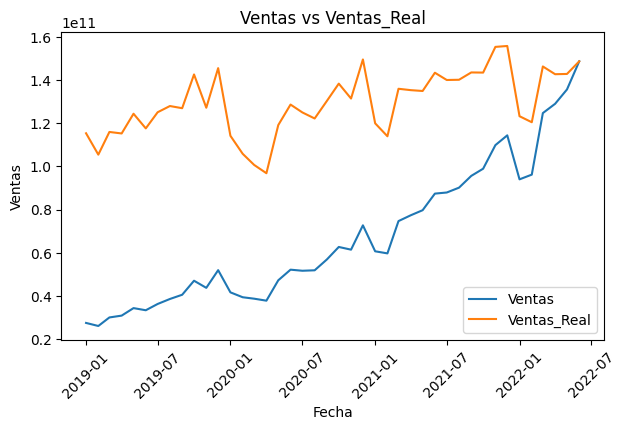

In [33]:
# Aplico la función para indexar valores respecto al último mes de la serie
indexar(ventas_ipc, 'Ventas')

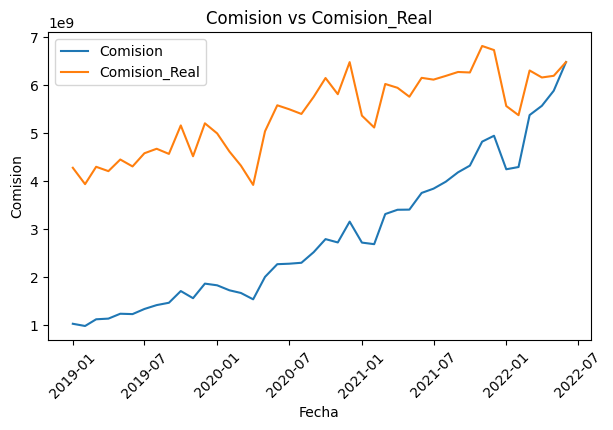

In [34]:
indexar(ventas_ipc, 'Comision')

Vemos gráficamente el efecto de la operación (por simplicidad se grafican mensualmente las series de tiempo agregando los valores por suma).

En las variantes llamadas "Reales", se observa una pendiente más moderada. El efecto de la inflación ha sido "descartado". De aquí en adelante, a la hora de hablar de los valores de estas variables, la interpretación correcta será "$ XX.XXX a precios de junio de 2022"

In [35]:
ventas_ipc.head(3)

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Subrubro,Omega,Modelo,Fecha,INDICE,Ventas_Real,Comision_Real
0,0,0,14622.16,0.028,409.42,0,Miscelaneo,1,0,2019-01-01,189.6101,6.115592e+04,1712.363645
1,1,1,62477.00,0.040,2499.08,0,Miscelaneo,1,0,2019-01-01,189.6101,2.613046e+05,10452.185376
2,1,2,3373941.00,0.040,134957.64,0,Miscelaneo,1,0,2019-01-01,189.6101,1.411122e+07,564448.625587


In [36]:
# Se descartan las variables que no se usan
ventas_ipc = limpiar_basic(ventas_ipc, cols_drop=['Ventas', 'Comision', 'INDICE'])

# Se renombran las variables
ventas_ipc.rename(columns = {'Ventas_Real': 'Ventas', 
                              'Comision_Real': 'Comision'}, inplace = True)

# Se reacomodan las columnas
ventas_ipc = ventas_ipc[['ID', 'Omega', 'Subrubro', 'Trat_Fisc', 'Fecha', 
                          'Deposito', 'Ventas', 'Alicuota', 'Comision', 'Modelo']]

ventas_ipc = ventas_ipc.sort_values(['Fecha', 'Ventas']).reset_index(drop=True)

In [37]:
ventas_ipc

,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,-1.116697e+07,2.00,-2.233394e+05,0
1,1172,1,Venta Agrop.,nan,2019-01-01,7,-5.494877e+06,2.40,-1.318771e+05,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,-2.331939e+06,4.00,-9.327756e+04,0
3,1907,1,Venta Agrop.,Norm,2019-01-01,5,-1.131988e+06,2.00,-2.263974e+04,0
4,1478,1,Venta Agrop.,nan,2019-01-01,7,-4.177637e+05,2.40,-1.002633e+04,0
...,...,...,...,...,...,...,...,...,...,...
378661,815,1,Supermercados,0,2022-06-01,8,1.567422e+09,0.05,7.837112e+07,0
378662,1098,1,Supermercados,Alícuota agravada,2022-06-01,130,1.732460e+09,5.00,8.662302e+07,0
378663,1091,1,Supermercados,Alícuota agravada,2022-06-01,130,2.240194e+09,5.00,1.120097e+08,0
378664,2862,1,Venta Agrop.,Alícuota agravada,2022-06-01,5,2.631098e+09,3.00,7.893293e+07,0


In [38]:
# Guardo todo lo hecho en el pretratamiento
ventas_ipc.to_csv('../data/interim/tp2_ventas_ipc.csv', index=False)

## Dataset resultante
El dataset original (`ventas`) teniá 435.489 registros y 19 variables. Luego de nuestro preprocesamiento nos quedamos con un dataset  (`ventas_ipc`) que tiene 378.666 registros y 10 variables.

In [39]:
ventas.shape

(435489, 19)

In [40]:
ventas_ipc.shape

(378666, 10)

---
# Análisis de variables categóricas

In [41]:
if 'ventas_ipc' not in locals():
    # Para que las funciones se actualicen sin tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_ipc = pd.read_csv('../data/interim/tp2_ventas_ipc.csv')

ventas_ipc.head()

,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,-1.116697e+07,2.0,-223339.447058,0
1,1172,1,Venta Agrop.,nan,2019-01-01,7,-5.494877e+06,2.4,-131877.053284,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,-2.331939e+06,4.0,-93277.561136,0
3,1907,1,Venta Agrop.,Norm,2019-01-01,5,-1.131988e+06,2.0,-22639.737670,0
4,1478,1,Venta Agrop.,nan,2019-01-01,7,-4.177637e+05,2.4,-10026.332056,0


In [42]:
ventas_categ = ventas_ipc.drop(['Ventas', 'Alicuota', 'Comision'], axis=1).copy()
ventas_categ.head(3)

,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,0
1,1172,1,Venta Agrop.,nan,2019-01-01,7,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,0


### `ID` y `Modelo`

In [43]:
checkear_unicidad(ventas_categ, 'Modelo', 'ID')

Para cada ID solo existe un valor de Modelo.


Esto implica, que si hay un vendedor Modelo que vende en más de un rubro, tiene la etiqueta de Modelo en todos los rubros.

### `Omega` y `Modelo`

En primer lugar, verificar si a cada ID único se le asigna un único valor de Omega (no debería pasar lo contrario)

In [44]:
checkear_unicidad(ventas_categ, 'Omega', 'ID')

Para cada ID solo existe un valor de Omega.


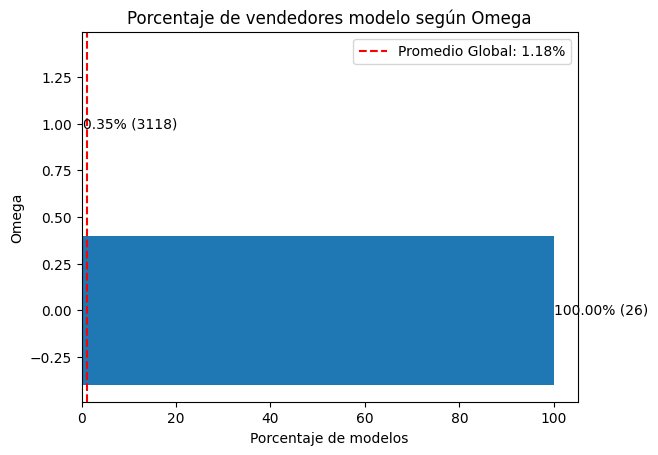

In [45]:
graficar_modelo(ventas_categ, 'Omega')

Dentro de los vendedores que son Omega (3119), solo el 0,35% es modelo.
Mientras que entre los no Omega (26), el 100% es modelo.

### `Subrubro` y `Modelo`

In [46]:
checkear_unicidad(ventas_categ, 'Subrubro', 'ID')

Para algunos ID se asignan diferentes valores de Subrubro:
ID
1992    10
1219    10
1479    10
1420     9
1530     9
        ..
1383     2
1384     2
1386     2
1390     2
3141     2
Name: Subrubro, Length: 1484, dtype: int64


En secciones previas se probó que si un ID era Modelo en un rubro, también lo era en todos en los que aparecía.

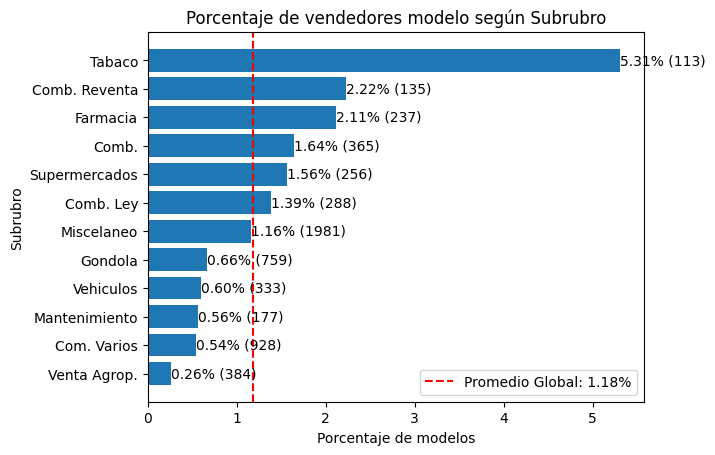

In [47]:
graficar_modelo(ventas_categ, 'Subrubro')

### `Trat_Fisc` y `Modelo`

In [48]:
checkear_unicidad(ventas_categ, 'Trat_Fisc', 'ID', 'Deposito', 'Subrubro', 'Fecha')

Para algunos ['ID', 'Deposito', 'Subrubro', 'Fecha'] se asignan diferentes valores de Trat_Fisc:
ID    Deposito  Subrubro    Fecha     
2145  9         Miscelaneo  2019-01-01    8
2910  46        Vehiculos   2019-02-01    7
2770  17        Farmacia    2021-09-01    7
2910  46        Vehiculos   2020-02-01    6
                            2019-01-01    6
                                         ..
1381  50        Miscelaneo  2021-05-01    2
                            2021-06-01    2
                            2021-07-01    2
                            2021-08-01    2
3074  31        Farmacia    2020-05-01    2
Name: Trat_Fisc, Length: 12667, dtype: int64


##### Checkear con `Ventas` si hay cierto punto de corte para pasar de una a otra categoría

In [49]:
ventas_prueba = ventas_ipc[['ID', 'Deposito', 'Subrubro', 'Fecha','Ventas','Trat_Fisc']].dropna(subset=['Trat_Fisc']).copy()
duplicados = ventas_prueba[ventas_prueba.duplicated(subset=['ID', 'Deposito', 'Subrubro', 'Fecha'], keep=False)].sort_values(by=['ID', 'Deposito', 'Subrubro', 'Fecha'], ascending=True).copy()
duplicados.groupby('Trat_Fisc')['Ventas'].mean()

Trat_Fisc
0                    8.946478e+06
1                    5.259615e+06
3                    3.460052e+07
Alícuota agravada    4.525596e+07
Alícuota reducida    1.308655e+07
Esp.1                1.070293e+08
Esp.2                8.177575e+07
Esp.3                6.895990e+07
Esp.4                2.298493e+08
Exento               3.671295e+07
MeraComp             7.119958e+07
Min                  5.382834e+06
Norm                 2.465215e+06
nan                  3.572062e+07
Name: Ventas, dtype: float64

Probamos con un caso.

Si resultado es True, significa que, dentro de cada grupo, el valor de 'Ventas' correspondiente a 'DESC_TRATAMIENTO_FISCAL' == 0 siempre es mayor que el valor de 'Ventas' correspondiente a 'DESC_TRATAMIENTO_FISCAL' == 1. Si resultado es False, significa que al menos en un grupo no se cumple esta condición.

In [50]:
resultado = duplicados.groupby(['ID', 'Deposito', 'Subrubro', 'Fecha']).apply(lambda x: x[x['Trat_Fisc'] == 0]['Ventas'].max() > x[x['Trat_Fisc'] == 1]['Ventas'].min()).all()
resultado

False

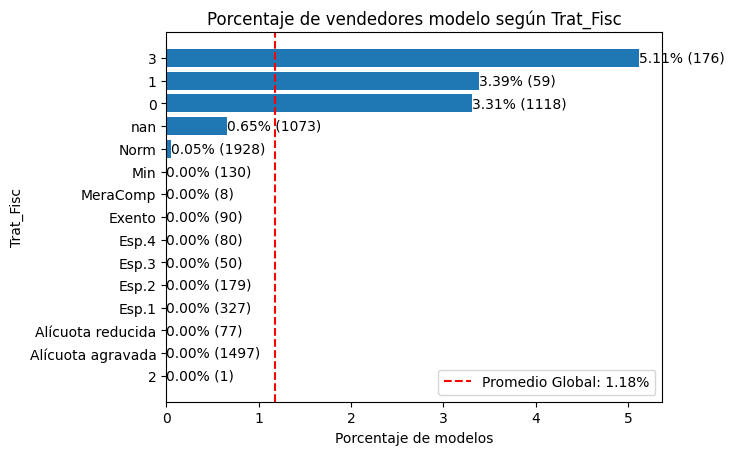

In [51]:
graficar_modelo(ventas_categ, 'Trat_Fisc')

---
# Análisis de variables numéricas

In [52]:
if 'ventas_ipc' not in locals():
    # Para que las funciones se actualicen sin tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_ipc = pd.read_csv('../data/interim/tp2_ventas_ipc.csv')

ventas_ipc.head()

,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,-1.116697e+07,2.0,-223339.447058,0
1,1172,1,Venta Agrop.,nan,2019-01-01,7,-5.494877e+06,2.4,-131877.053284,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,-2.331939e+06,4.0,-93277.561136,0
3,1907,1,Venta Agrop.,Norm,2019-01-01,5,-1.131988e+06,2.0,-22639.737670,0
4,1478,1,Venta Agrop.,nan,2019-01-01,7,-4.177637e+05,2.4,-10026.332056,0


In [53]:
# Discrimanción por variables numércias
num_cols = ['Ventas', 'Alicuota', 'Comision']
ven_num = ventas_ipc[num_cols]

## Estadística descriptiva

- Vemos que en la variable `Alicuota` la dispersión de los datos está en el orden de la media, tomando valores desde 0% hasta 18%. Esto se ve reflejado en un z-Score que va desde -1 a 6 (igual al tp1).
- Esta tendencia a tener la cola derecha más larga también se nota en las otras dos variables. Sin embargo, en estos dos últimos casos la dispersión de datos es enorme: la desviación estándar es igual y un orden mayor que la media y el extremo superior del z-Score está en 83 y 108 para `Ventas` y `Comision`, respectivamente (mejoró respecto al tp1 gracias a la normalización por IPC).

In [54]:
ven_num.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,378666.0,1.435347e+07,7.355886e+07,-3.475437e+08,0.00,374511.023247,7.884979e+06,6.894934e+09
Alicuota,378666.0,3.203412e+00,2.784095e+00,0.000000e+00,0.05,4.000000,4.750000e+00,1.800000e+01
Comision,378666.0,5.979122e+05,3.193656e+06,-1.216403e+07,0.00,15286.747647,3.283902e+05,3.447467e+08


In [55]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num[col].min() - ven_num[col].mean()) / ven_num[col].std()
    zScore_max = (ven_num[col].max() - ven_num[col].mean()) / ven_num[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Ventas:
		 Mínimo: -5 	 Máximo: 94
	Alicuota:
		 Mínimo: -1 	 Máximo: 5
	Comision:
		 Mínimo: -4 	 Máximo: 108


- Tanto `Ventas` como `Comision` tienen prácticamente un 39% de registros con valores nulos y un 0.3% de valores negativos, *i.e.* hay un 40% de registros con valores no positivos imputados. 
- Un valor nulo significa que o bien era realmente nulo o se encontraba entre -$100 y $1000 (en la variable original de ventas).
- `Alicuota` no posee registros negativos, pero sí tiene un 0.62% de registros nulos.

In [56]:
print('Proporción de valores negativos, nulos y positivos en las variables numéricas:') 
for col in num_cols:
    print(f'\t{col}')
    ans = len(ven_num[col])
    neg = len(ven_num[ven_num[col] < 0])
    nul = len(ven_num[ven_num[col] == 0])

    cant = [neg, nul, neg+nul, ans-neg-nul, ans]
    prop = [f'{100*neg/ans:.2f}%', f'{100*nul/ans:.2f}%', f'{100*(nul+neg)/ans:.2f}%', f'{100*(ans-nul-neg)/ans:.2f}%', '100.00%']
    desc = pd.DataFrame([cant, prop], columns=['Negativos', 'Nulos', 'No positivos', 'Positivos', 'Total'], index=['Cantidad', 'Proporcion'])
    display(desc)


Proporción de valores negativos, nulos y positivos en las variables numéricas:
	Ventas


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,1233,147019,148252,230414,378666
Proporcion,0.33%,38.83%,39.15%,60.85%,100.00%


	Alicuota


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,0,2337,2337,376329,378666
Proporcion,0.00%,0.62%,0.62%,99.38%,100.00%


	Comision


,Negativos,Nulos,No positivos,Positivos,Total
Cantidad,1207,149277,150484,228182,378666
Proporcion,0.32%,39.42%,39.74%,60.26%,100.00%


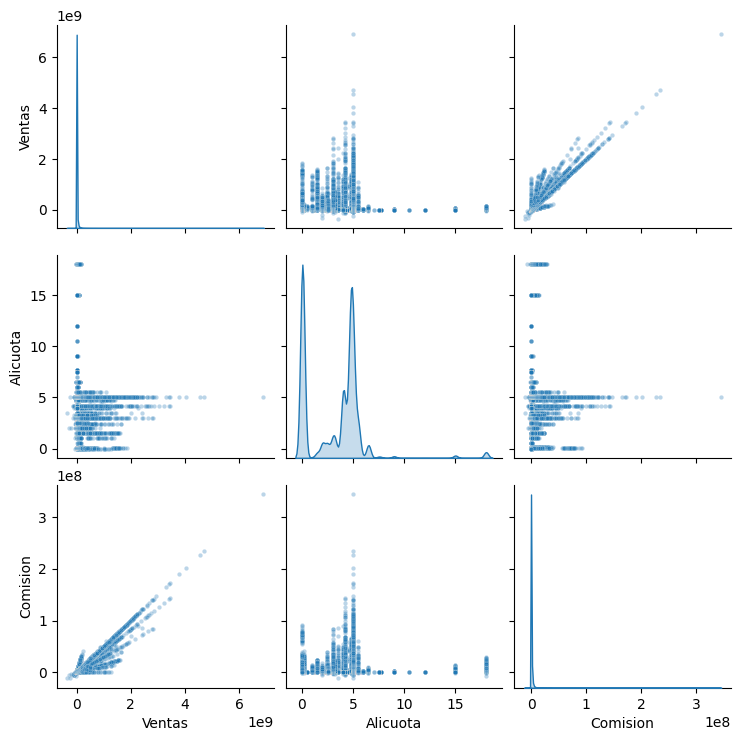

In [57]:
sns.pairplot(data=ven_num, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

<Axes: >

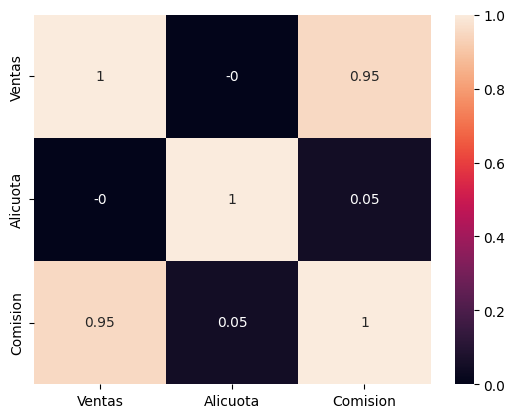

In [58]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

## Discriminando por tipo de venta
Dado el enorme peso de los valores nulos sobre el total de registros y la presencia de valores negativos, tanto en `Ventas` como en `Comision`, se decide dividir este DataFrame en tres:
1. Filtrado por `Ventas` nulas (`ven_num_null`)
2. Filtrado por `Ventas` negativas (`ven_num_neg`)
2. Filtrado por `Ventas` positivas (`ven_num_pos`)

### DataFrame con todas las ventas nulas
- Al hacer esto, vemos que todos los valores de `Comision` en `ven_num_null` también son nulos, independientemente del valor de `Alicuota`, la cual sigue ocupando el rango de 0% a 18%.
- Existen registros de vendedores modelo con ventas nulas.

In [59]:
ven_num_null = ven_num[ven_num['Ventas'] == 0].copy()
ven_num_null.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,147019.0,0.000000,0.000000,0.0,0.000,0.0,0.00,0.0
Alicuota,147019.0,3.494511,2.746759,0.0,0.055,4.6,4.75,18.0
Comision,147019.0,0.000000,0.000000,0.0,0.000,0.0,0.00,0.0


In [60]:
mod_null = ventas_ipc[num_cols+['Modelo']]
mod_null = mod_null[mod_null['Ventas'] == 0]
mod_null.sort_values('Modelo')

,Ventas,Alicuota,Comision,Modelo
12,0.0,0.020,0.0,0
257555,0.0,4.750,0.0,0
257554,0.0,4.750,0.0,0
257553,0.0,5.500,0.0,0
257552,0.0,4.750,0.0,0
...,...,...,...,...
228263,0.0,0.050,0.0,1
228264,0.0,0.090,0.0,1
228265,0.0,0.090,0.0,1
237752,0.0,0.065,0.0,1


In [61]:
print('z-Score de los extremos de la variables numéricas:') 
for col in ['Alicuota']:
    zScore_min = (ven_num_null[col].min() - ven_num_null[col].mean()) / ven_num_null[col].std()
    zScore_max = (ven_num_null[col].max() - ven_num_null[col].mean()) / ven_num_null[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Alicuota:
		 Mínimo: -1 	 Máximo: 5


### DataFrame con todas las ventas negativas
- Hay 7 órdenes de magnitud de diferencia entre los valores mínimo y máximo de ventas y comisión.
- Los datos son asimétricos hacia la izquierda, igual son menos asimétricos que el conjunto global
- Hay 26 casos donde la comisión es nula a pesar de que la venta no fue nula. En 25 de estos casos ocurre que la alícuota es cero. En el caso restante es de 0.18%. Como en todos los casos son ventas negativas, puede ser que esta sea la razón de tener una comisión nula. Ninguno de estos 26 registros corresponde a vendedor modelo.
- De hecho no hay ningún modelo con ventas negativas.

In [62]:
ven_num_neg = ven_num[ven_num['Ventas'] < 0].copy()
ven_num_neg.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,1233.0,-5.017765e+06,2.036540e+07,-3.475437e+08,-2.001097e+06,-178021.212455,-15325.640441,-0.716723
Alicuota,1233.0,4.484690e+00,2.368225e+00,0.000000e+00,4.000000e+00,5.000000,5.000000,18.000000
Comision,1233.0,-2.087849e+05,7.849380e+05,-1.216403e+07,-8.551876e+04,-7400.433227,-662.316682,0.000000


In [63]:
mod_neg = ventas_ipc[num_cols+['Modelo']]
mod_neg = mod_neg[mod_neg['Ventas'] < 0]
mod_neg.sort_values('Modelo')

,Ventas,Alicuota,Comision,Modelo
0,-1.116697e+07,2.00,-223339.447058,0
237093,-1.217173e+06,4.75,-57815.735249,0
237092,-1.455246e+06,5.00,-72762.302185,0
237091,-1.613046e+06,5.00,-80652.281149,0
237090,-1.645909e+06,5.00,-82295.428769,0
...,...,...,...,...
128450,-6.010615e+06,5.00,-300530.738257,0
128449,-6.032051e+06,5.00,-301602.558821,0
128448,-6.079995e+06,5.00,-303999.764849,0
128455,-5.495365e+06,5.00,-274768.253058,0


In [64]:
ventas_ipc[(ventas_ipc['Ventas'] < 0) & (ventas_ipc['Comision'] == 0)].sort_values('Alicuota')[num_cols+['Modelo']]

,Ventas,Alicuota,Comision,Modelo
8606,-1.923419e+03,0.00,0.0,0
302842,-1.526624e+02,0.00,0.0,0
293365,-1.687148e+02,0.00,0.0,0
283914,-1.036719e+02,0.00,0.0,0
274492,-1.062303e+02,0.00,0.0,0
265085,-3.399154e+02,0.00,0.0,0
255727,-2.567524e+03,0.00,0.0,0
237195,-5.777133e+02,0.00,0.0,0
237174,-4.546783e+03,0.00,0.0,0
237088,-1.694287e+06,0.00,0.0,0


In [65]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num_neg[col].min() - ven_num_neg[col].mean()) / ven_num_neg[col].std()
    zScore_max = (ven_num_neg[col].max() - ven_num_neg[col].mean()) / ven_num_neg[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Ventas:
		 Mínimo: -17 	 Máximo: 0
	Alicuota:
		 Mínimo: -2 	 Máximo: 6
	Comision:
		 Mínimo: -15 	 Máximo: 0


* La mayoría de las ventas y comisiones están asociadas a alícuotas menores al 5% (con moda en 5%).
* Se proyecta una relación lineal entre `Ventas` y `Comision`: hay una correlación de +0.92. Chequear relación de proporcionaldiad con `Alicuota`.

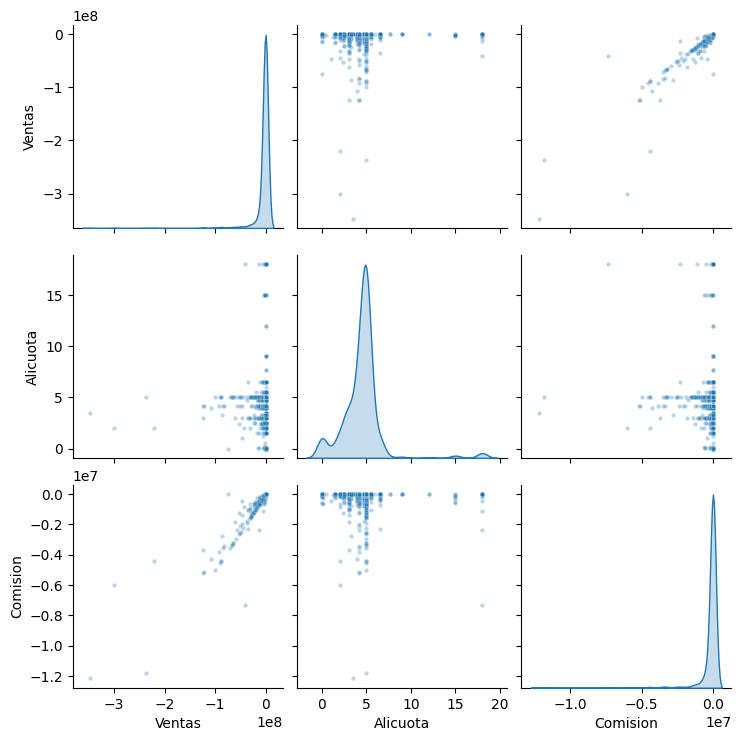

In [66]:
sns.pairplot(data=ven_num_neg, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

<Axes: >

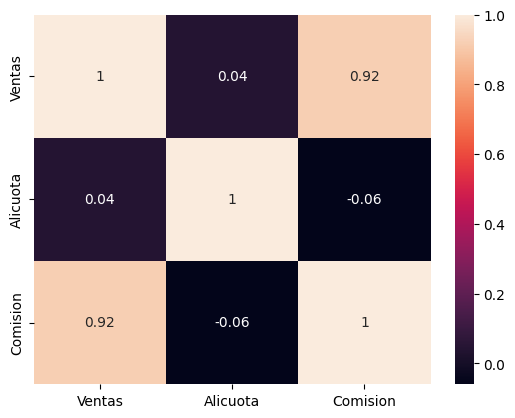

In [67]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num_neg[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

### DataFrame con todas las ventas positivas
* Hay 5 y 9 órdenes de magnitud de diferencia entre los valores mínimo y máximo de comisión y ventas, respectivamente.
* Los datos son asimétricos hacia la derecha, igual son menos asimétricos que el conjunto global.
* Hay 2232 casos donde la comisión es nula a pesar de que la venta no fue nula. De estos:
    * 34 registros corresponden a vendedores modelo.
    * 1458 registros con alícuota nula.
    * 774 registros con alícuota no nula.

In [68]:
ven_num_pos = ven_num[ven_num['Ventas'] > 0].copy()
ven_num_pos.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,230414.0,2.361557e+07,9.311775e+07,0.01,793537.203571,4.897819e+06,1.797292e+07,6.894934e+09
Alicuota,230414.0,3.010815e+00,2.791867e+00,0.00,0.047500,4.000000e+00,5.000000e+00,1.800000e+01
Comision,230414.0,9.837355e+05,4.046999e+06,0.00,32387.328981,2.022052e+05,7.519536e+05,3.447467e+08


In [69]:
a = ventas_ipc[(ventas_ipc['Ventas'] > 0) & (ventas_ipc['Comision'] == 0)].sort_values('Alicuota')[num_cols+['Modelo']]
display(a)
print(f'Hay {len(a)} registros con venta positiva, pero comisión nula. De estos:')
print(f'\t>>> {len(a[a["Modelo"] == 1])} registros corresponden a vendedores modelo.')
display(a[a["Modelo"] == 1].describe().T)
print(f'\t>>> {len(a[a["Alicuota"] == 0])} registros con alícuota nula.')
print(f'\t>>> {len(a[a["Alicuota"] > 0])} registros con alícuota no nula.')
display(a[a["Alicuota"] > 0].describe().T)

,Ventas,Alicuota,Comision,Modelo
378637,6.476255e+08,0.0,0.0,0
194734,3.376952e+04,0.0,0.0,0
194725,3.191202e+04,0.0,0.0,0
327093,6.523777e+05,0.0,0.0,0
327627,1.511551e+06,0.0,0.0,0
...,...,...,...,...
122991,2.595398e-02,18.0,0.0,0
122992,2.595398e-02,18.0,0.0,0
114324,2.682174e-02,18.0,0.0,0
105655,2.736184e-02,18.0,0.0,0


Hay 2232 registros con venta positiva, pero comisión nula. De estos:
	>>> 34 registros corresponden a vendedores modelo.


,count,mean,std,min,25%,50%,75%,max
Ventas,34.0,6.162132e+06,4.106594e+06,130144.773973,2.755914e+06,6.427763e+06,8.610708e+06,1.850493e+07
Alicuota,34.0,2.176471e-02,7.164977e-03,0.020000,2.000000e-02,2.000000e-02,2.000000e-02,5.000000e-02
Comision,34.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Modelo,34.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


	>>> 1458 registros con alícuota nula.
	>>> 774 registros con alícuota no nula.


,count,mean,std,min,25%,50%,75%,max
Ventas,774.0,1.117339e+07,3.063744e+07,0.010,0.030261,1.034714e+06,8.972774e+06,2.642014e+08
Alicuota,774.0,1.519954e+00,3.226284e+00,0.015,0.020000,4.750000e-02,7.500000e-02,1.800000e+01
Comision,774.0,0.000000e+00,0.000000e+00,0.000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Modelo,774.0,4.392765e-02,2.050667e-01,0.000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00


In [70]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num_pos[col].min() - ven_num_pos[col].mean()) / ven_num_pos[col].std()
    zScore_max = (ven_num_pos[col].max() - ven_num_pos[col].mean()) / ven_num_pos[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

z-Score de los extremos de la variables numéricas:
	Ventas:
		 Mínimo: -0 	 Máximo: 74
	Alicuota:
		 Mínimo: -1 	 Máximo: 5
	Comision:
		 Mínimo: -0 	 Máximo: 85


* La mayoría de las ventas y comisiones están asociadas a alícuotas menores al 5%.
* Hay una distribución bimodal en torno al 0.0475% y el 5%
* Se proyectan diferentes rectas entre `Ventas` y `Comision`: ¿existe una relación de proporcionaldiad con `Alicuota`?
* Se proyecta una relación lineal entre `Ventas` y `Comision`: hay una correlación de +0.95. Chequear relación de proporcionaldiad con `Alicuota`

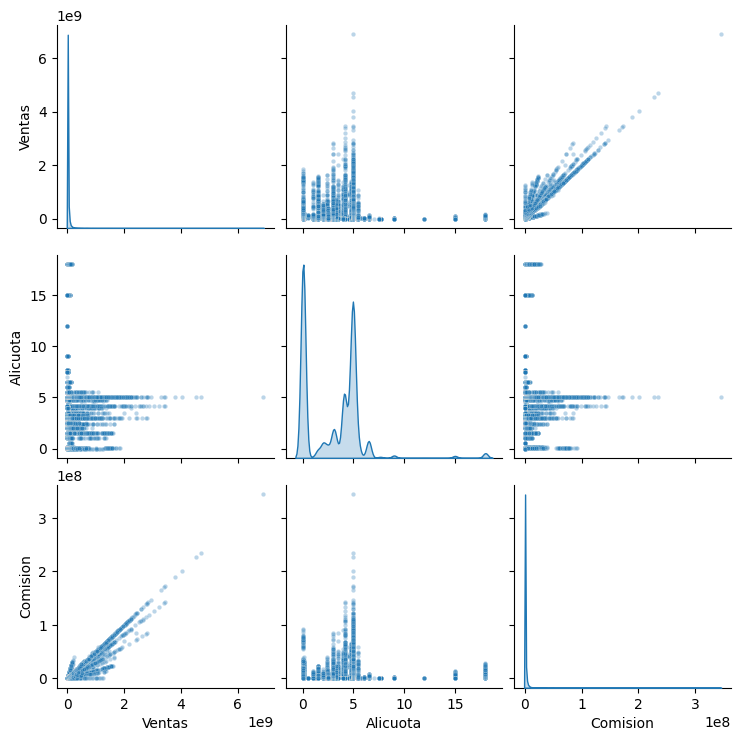

In [71]:
sns.pairplot(data=ven_num_pos, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

<Axes: >

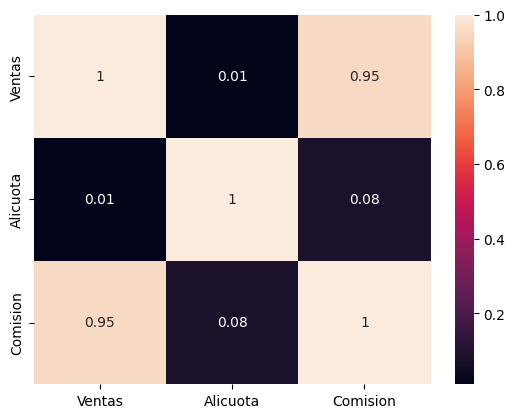

In [72]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num_pos[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

## Más medidas de dispersión sobre ventas no nulas: asimetría y Kurtosis

Al analizar la asimetría (skewness) y la Kurtosis sobre estas variables decimos que:
* Las ventas positivas tienen un sesgo positivos y las negativas un sesgo negativo tanto para comisión como para ventas, como ya habíamos visto: las colas de las distribuciones se encuentran a derecha e izquierda, respectivamente.
* Las comisiones siempre tienen sesgo positivo: colas a derecha.
* Todas son leptocúrticas: están más apuntaladas y con colas más gruesas que la normal.
* Todos los p-valores son nulos en ambos test, lo cual indica que rechazamos la hipótesis nula: tanto en simetría como en Kurtosis las distribuciones son significativamente diferentes a una distribución normal.

In [73]:
print('Ventas negativas')
asim = skew(ven_num_neg)
asimtest = skewtest(ven_num_neg).pvalue
kurt = kurtosis(ven_num_neg)
kurttest = kurtosistest(ven_num_neg).pvalue

desc = pd.DataFrame({'Asimetría': asim, 'p-val Asim.': asimtest,
                     'Kurtosis (Fisher)': kurt, 'p-val Kurt.': kurttest},
                     index=['Ventas', 'Alicuota', 'Comision'])
desc

Ventas negativas


,Asimetría,p-val Asim.,Kurtosis (Fisher),p-val Kurt.
Ventas,-9.845730,0.000000e+00,127.533086,2.871108e-118
Alicuota,2.755404,1.940313e-115,15.245549,3.229661e-63
Comision,-8.452926,1.123207e-282,97.383275,2.644955e-112


In [74]:
print('Ventas positivas')
asim = skew(ven_num_pos)
asimtest = skewtest(ven_num_pos).pvalue
kurt = kurtosis(ven_num_pos)
kurttest = kurtosistest(ven_num_pos).pvalue

desc = pd.DataFrame({'Asimetría': asim, 'p-val Asim.': asimtest,
                     'Kurtosis (Fisher)': kurt, 'p-val Kurt.': kurttest},
                     index=['Ventas', 'Alicuota', 'Comision'])
desc

Ventas positivas


,Asimetría,p-val Asim.,Kurtosis (Fisher),p-val Kurt.
Ventas,16.564224,0.0,469.714264,0.0
Alicuota,1.444401,0.0,6.241373,0.0
Comision,19.664820,0.0,689.741211,0.0


## Relación entre variables numéricas con etiquetas categóricas

In [75]:
ventas_null = ventas_ipc[ventas_ipc['Ventas'] == 0].copy()
ventas_neg = ventas_ipc[ventas_ipc['Ventas'] < 0].copy()
ventas_pos = ventas_ipc[ventas_ipc['Ventas'] > 0].copy()

### Ventas nulas
- Omega: prácticamente todos 1. Hay una nadita de 0.
- Subrubro: nada particular.
- Trat_Fisc: la enorme mayoría son 0. Después destacan apenitas los normales.
- Modelo: la gran mayoría no lo son, aunque sí hay varios modelo (en torno al cero).

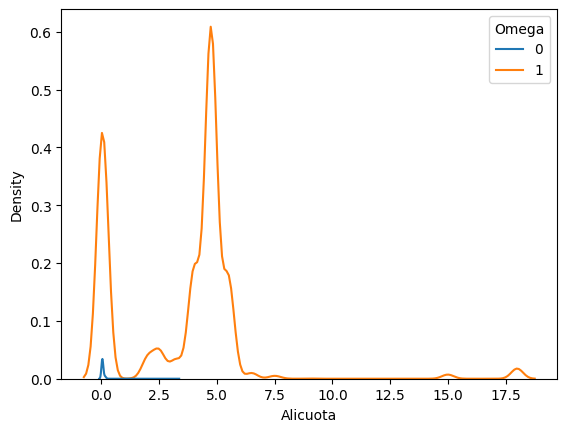

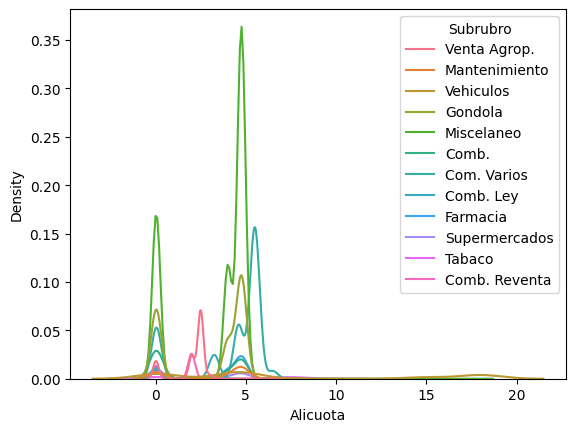

C:\Users\Patricio\AppData\Local\Temp\ipykernel_4056\3874654132.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=ventas_null[['Alicuota', col]], x='Alicuota', hue=col)


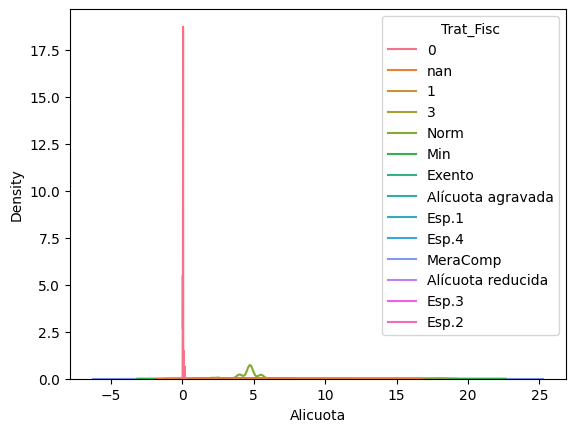

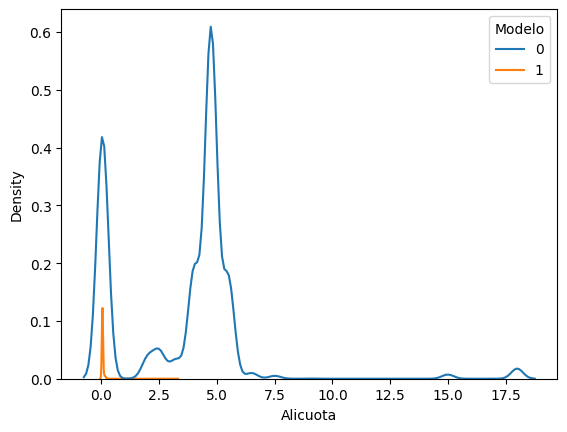

In [76]:
# Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

for col in ['Omega', 'Subrubro', 'Trat_Fisc','Modelo']:
    sns.kdeplot(data=ventas_null[['Alicuota', col]], x='Alicuota', hue=col)
    plt.show()

### Ventas negativas
- Omega: todos son 1.
- Subrubro: destacan misceláneo, supermercados y combustible reventa.
- Trat_Fisc: nada particular.
- Modelo: todos son 0 (no hay ningún modelo con ventas negativas).

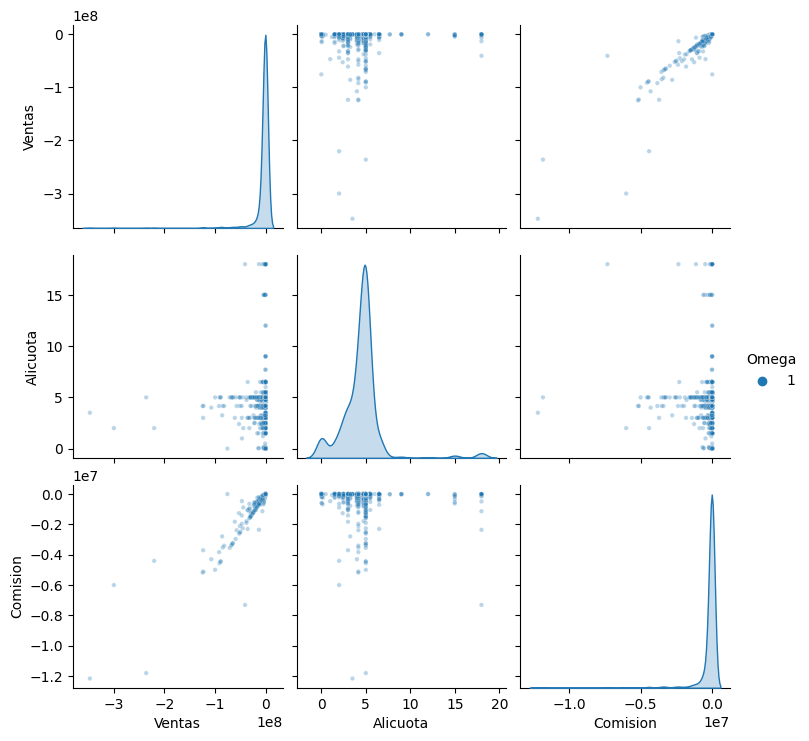

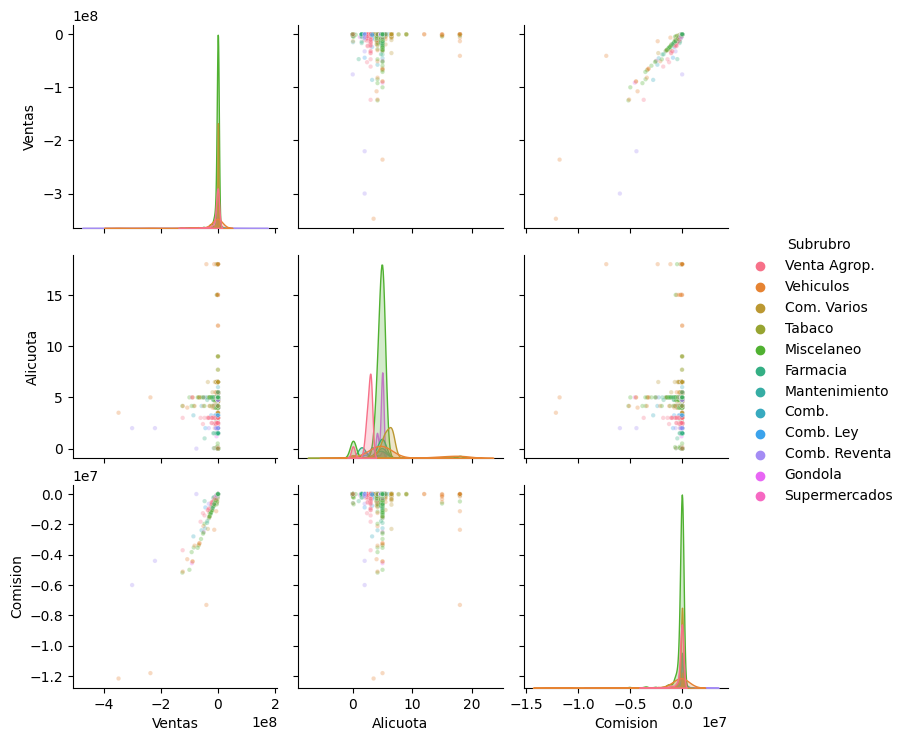

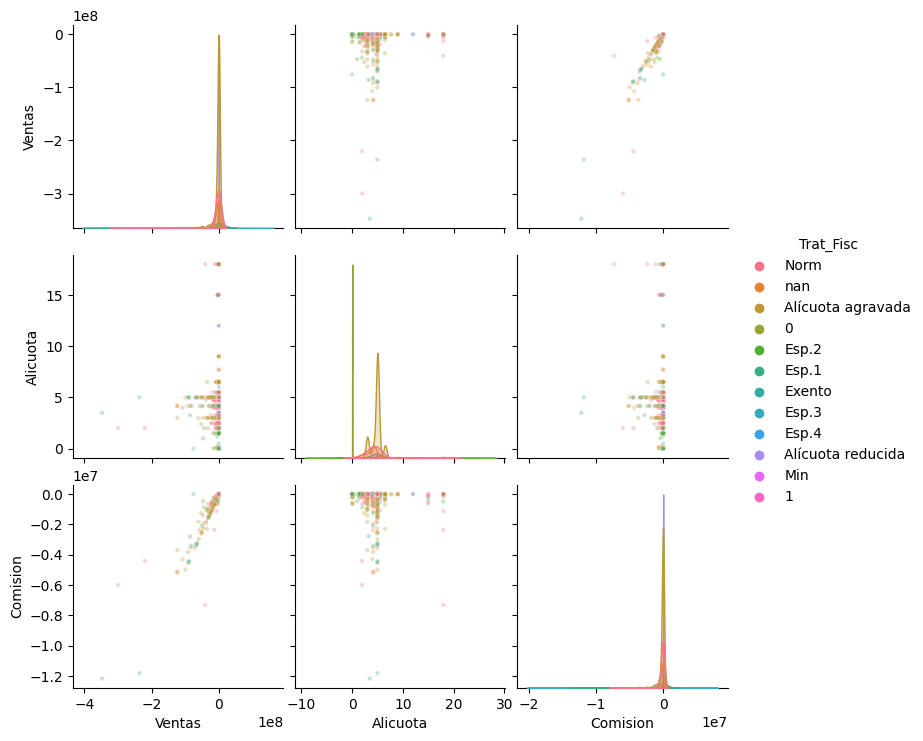

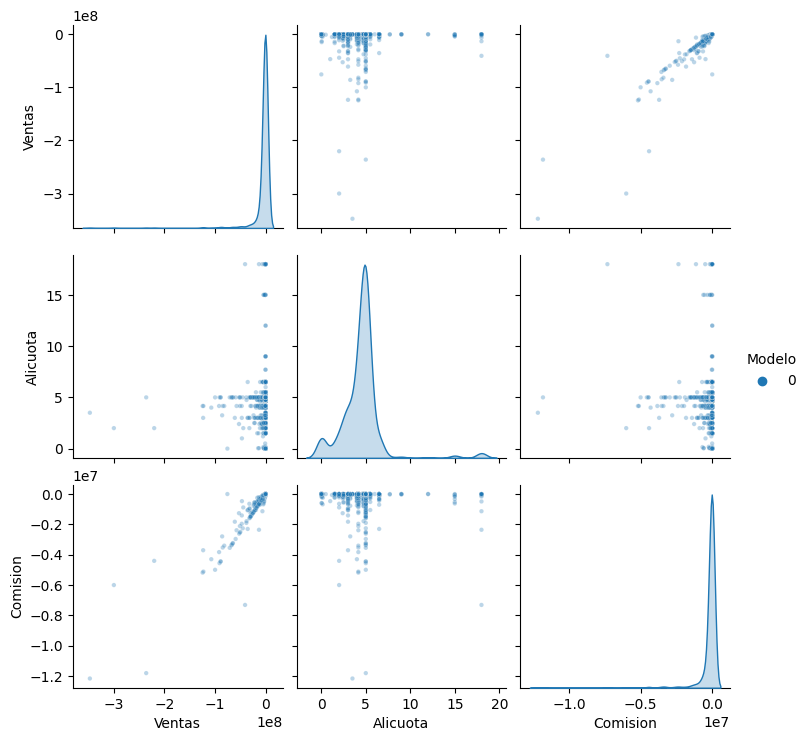

In [77]:
# Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

for col in ['Omega', 'Subrubro', 'Trat_Fisc', 'Modelo']:
    sns.pairplot(data=ventas_neg[num_cols+[col]], diag_kind='kde', hue=col, plot_kws = {'alpha': 0.3, 's': 10})
    plt.show()

### Ventas positivas
- Omega: la enorme mayoría son 1. Hay poquititos 0.
- Subrubro: ver cómo se asocian a las diferentes proyecciones.
- Trat_Fisc: nada particular.
- Modelo: hay tanto 0 como 1. Hay una mayor proporción de 1 que antes

In [ ]:
# Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

for col in ['Omega', 'Subrubro', 'Trat_Fisc', 'Modelo']:
    sns.pairplot(data=ventas_pos[num_cols+[col]], diag_kind='kde', hue=col, plot_kws = {'alpha': 0.3, 's': 10})
    plt.show()

## Nota sobre modelos
* No hay ningún modelo con ventas nulas: la mayoría de sus registros son ventas positivas, aunque hay algunos con ventas negativas.
* Todos los modelos tienen alícuotas bajas (muy ceranas al 0%). Hay 5374 registros asociados a vendedores modelo y sus alícuotas van desde 0.0084% hasta 3.25%. Sin embargo, la mayoría se concentra en alícuotas menores a 0.075 %, teniendo un pico en 0.05%.

In [78]:
a = ventas_ipc[(ventas_ipc['Modelo'] == 1)].sort_values('Alicuota')[num_cols]
a.describe().T

,count,mean,std,min,25%,50%,75%,max
Ventas,5374.0,8.581049e+06,1.780843e+07,0.0000,23402.462265,1.195790e+06,9.288999e+06,1.604163e+08
Alicuota,5374.0,4.341396e-02,4.746062e-02,0.0084,0.030000,4.550000e-02,5.000000e-02,3.250000e+00
Comision,5374.0,3.286417e+05,6.574324e+05,0.0000,614.392644,4.598210e+04,3.347940e+05,5.213529e+06


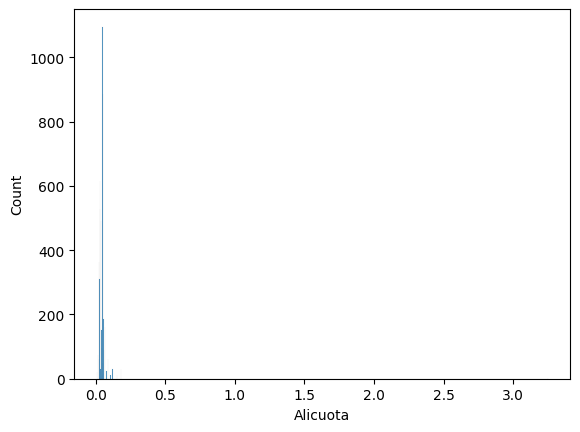

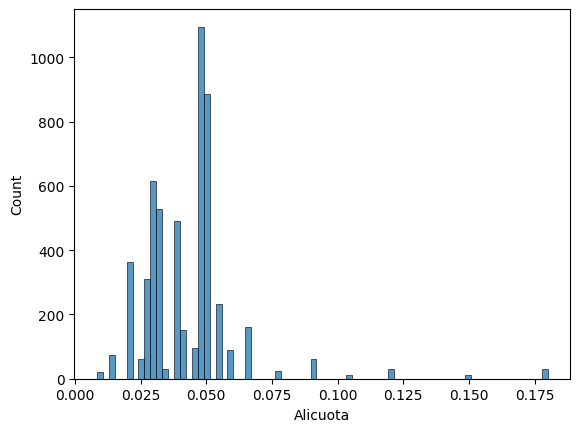

In [79]:
sns.histplot(a['Alicuota'])
plt.show()

sns.histplot(a[a['Alicuota'] < 0.5]['Alicuota'])
plt.show()

## Análisis de la relación de proporcionalidad entre variables numéricas

Queremos estudiar un poco más la relación lineal antes vista entre estas 3 variables. Proponemos que la función que las relaciona es
    $$\text{Comision} = \text{Alicuota} \times \text{Ventas}$$

Acá voy a volver a distinguir entre nulas, positivas y negativas e ir discriminando por modelo

### Ventas nulas
Los 147019 registros con ventas nulas cumplen la relación (porque dijimos que toda venta nula estaba asociada a una comision nula).

In [80]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_null['Alicuota'] * ventas_null['Ventas']

L = len(calcCom)
S = sum(abs(ventas_null['Comision'] - calcCom) == 0)
print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

147019 de 147019 registros cumplen la relación >> 100.00%
0 registros no la cumplen la relación >> 0.00%


### Ventas negativas
* El 97.65% de los registros **NO** cumplen la relación: el 96.19% de los registros la subestiman.
* El 97.65% de los registros cae en el caso *pendiente grande*.

In [81]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_neg['Alicuota'] * ventas_neg['Ventas']

diff = ventas_neg['Comision'] - calcCom
D = len(diff)
L = len(calcCom)
S = sum(abs(diff) == 0)

print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

sobre = len(diff[diff<0])
print(f'\t{sobre} registros sobreestiman la relación >>> {100*sobre/D:.2f}%')
sub = len(diff[diff>0])
print(f'\t{sub} registros subestiman la relación >>> {100*sub/D:.2f}%')

30 de 1233 registros cumplen la relación >> 2.43%
1203 registros no la cumplen la relación >> 97.57%
	17 registros sobreestiman la relación >>> 1.38%
	1186 registros subestiman la relación >>> 96.19%


In [85]:
com_real_sobre = ventas_neg['Comision'][diff<0]
com_real_exac = ventas_neg['Comision'][diff==0]
com_real_sub = ventas_neg['Comision'][diff>0]

com_calc_sobre = calcCom[diff<0]
com_calc_exac = calcCom[diff==0]
com_calc_sub = calcCom[diff>0]

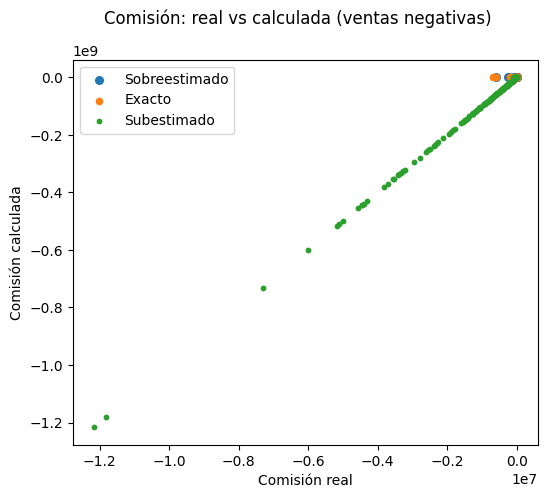

In [83]:
fig, axs = plt.subplots(figsize=(6, 5))

fig.suptitle('Comisión: real vs calculada (ventas negativas)')

axs.scatter(com_real_sobre, com_calc_sobre, label='Sobreestimado', s=30)
axs.scatter(com_real_exac, com_calc_exac, label='Exacto', s=20)
axs.scatter(com_real_sub, com_calc_sub, label='Subestimado', s=10)

axs.legend()

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

plt.show()

In [84]:
rg_real = pd.concat([com_real_sub[com_calc_sub<0], com_real_sobre[com_calc_sobre>10*com_real_sobre]])
rg_calc = pd.concat([com_calc_sub[com_calc_sub<0], com_calc_sobre[com_calc_sobre>10*com_real_sobre]])

rp_real = pd.concat([com_real_sub[com_calc_sub>0], com_real_sobre[com_calc_sobre<10*com_real_sobre], com_real_exac])
rp_calc = pd.concat([com_calc_sub[com_calc_sub>0], com_calc_sobre[com_calc_sobre<10*com_real_sobre], com_calc_exac])

In [86]:
print(f'De los {len(rp_real+rg_real)} registros:')
print(f'\t{len(rg_real)} están en la recta con pendiente grande >>> {100*len(rg_real)/len(rp_real+rg_real):.2f}%')
print(f'\t{len(rp_real)} están en la recta con pendiente pequeña >>> {100*len(rp_real)/len(rp_real+rg_real):.2f}%')

De los 1233 registros:
	1203 están en la recta con pendiente grande >>> 97.57%
	30 están en la recta con pendiente pequeña >>> 2.43%


In [87]:
LG = LR(rg_real, rg_calc)
LP = LR(rp_real, rp_calc)

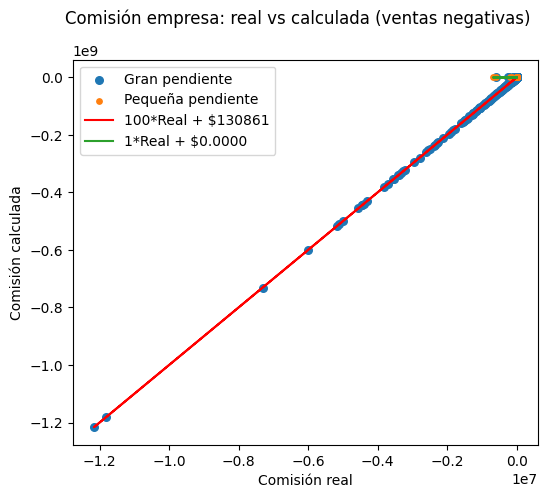

In [88]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(rg_real, rg_real*LG.slope + LG.intercept, label=f'{LG.slope:.0f}*Real + ${LG.intercept:.0f}', color='red')
axs.plot(rp_real, rp_real*LP.slope + LP.intercept, label=f'{LP.slope:.0f}*Real + ${LP.intercept:.4f}', color='tab:green')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada (ventas negativas)')
plt.show()

### Ventas positivas
* El 97.33% de los registros **NO** cumplen la relación: el 81.64% de los registros la sobrestiman.
* El 64.05% caen en el caso *pendiente grande*.
* Todos os modelo caen en el caso *pendiente pequeña*.

In [89]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_pos['Alicuota'] * ventas_pos['Ventas']

diff = ventas_pos['Comision'] - calcCom
D = len(diff)
L = len(calcCom)
S = sum(abs(diff) == 0)

print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

sobre = len(diff[diff<0])
print(f'\t{sobre} registros sobreestiman la relación >>> {100*sobre/D:.2f}%')
sub = len(diff[diff>0])
print(f'\t{sub} registros subestiman la relación >>> {100*sub/D:.2f}%')

6782 de 230414 registros cumplen la relación >> 2.94%
223632 registros no la cumplen la relación >> 97.06%
	187875 registros sobreestiman la relación >>> 81.54%
	35757 registros subestiman la relación >>> 15.52%


In [90]:
com_real_sobre = ventas_pos['Comision'][diff<0]
com_real_exac = ventas_pos['Comision'][diff==0]
com_real_sub = ventas_pos['Comision'][diff>0]

com_calc_sobre = calcCom[diff<0]
com_calc_exac = calcCom[diff==0]
com_calc_sub = calcCom[diff>0]

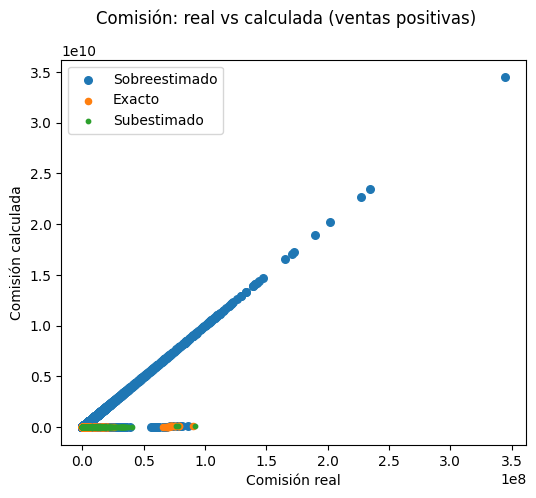

In [91]:
fig, axs = plt.subplots(figsize=(6, 5))

fig.suptitle('Comisión: real vs calculada (ventas positivas)')

axs.scatter(com_real_sobre, com_calc_sobre, label='Sobreestimado', s=30)
axs.scatter(com_real_exac, com_calc_exac, label='Exacto', s=20)
axs.scatter(com_real_sub, com_calc_sub, label='Subestimado', s=10)

axs.legend()

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

plt.show()

In [92]:
rg_real = pd.concat([com_real_sub[com_calc_sub<0], com_real_sobre[com_calc_sobre>10*com_real_sobre]])
rg_calc = pd.concat([com_calc_sub[com_calc_sub<0], com_calc_sobre[com_calc_sobre>10*com_real_sobre]])

rp_real = pd.concat([com_real_sub[com_calc_sub>0], com_real_sobre[com_calc_sobre<10*com_real_sobre], com_real_exac])
rp_calc = pd.concat([com_calc_sub[com_calc_sub>0], com_calc_sobre[com_calc_sobre<10*com_real_sobre], com_calc_exac])

In [93]:
print(f'De los {len(rp_real+rg_real)} registros:')
print(f'\t{len(rg_real)} están en la recta con pendiente grande >>> {100*len(rg_real)/len(rp_real+rg_real):.2f}%')
print(f'\t{len(rp_real)} están en la recta con pendiente pequeña >>> {100*len(rp_real)/len(rp_real+rg_real):.2f}%')

De los 230414 registros:
	147581 están en la recta con pendiente grande >>> 64.05%
	82833 están en la recta con pendiente pequeña >>> 35.95%


In [94]:
LG = LR(rg_real, rg_calc)
LP = LR(rp_real, rp_calc)

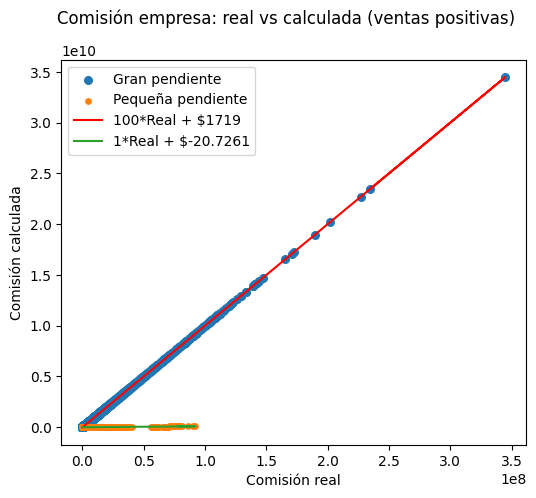

In [95]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(rg_real, rg_real*LG.slope + LG.intercept, label=f'{LG.slope:.0f}*Real + ${LG.intercept:.0f}', color='red')
axs.plot(rp_real, rp_real*LP.slope + LP.intercept, label=f'{LP.slope:.0f}*Real + ${LP.intercept:.4f}', color='tab:green')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada (ventas positivas)')
plt.show()

In [96]:
# Discrimino por modelo
mask0 = ventas_pos['Modelo']==0
mask1 = ventas_pos['Modelo']==1

In [97]:
com_real_Mod = ventas_pos['Comision'][mask1]
com_real_noMod = ventas_pos['Comision'][mask0]

com_calc_Mod = calcCom[mask1]
com_calc_noMod = calcCom[mask0]

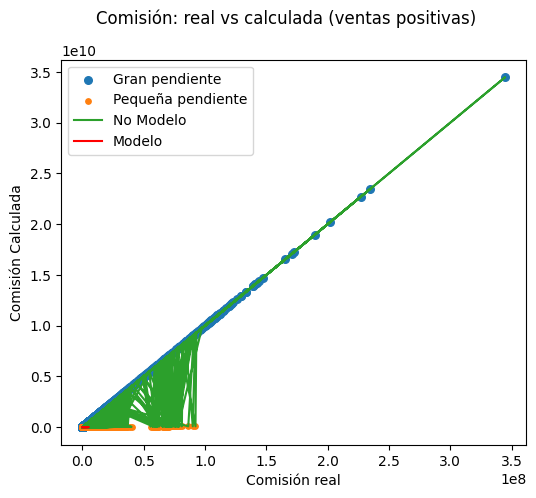

In [98]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(com_real_noMod, com_calc_noMod, label='No Modelo', color='tab:green')
axs.plot(com_real_Mod, com_calc_Mod, label='Modelo', color='red')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión Calculada')

fig.suptitle('Comisión: real vs calculada (ventas positivas)')
plt.show()

### Pendientes
* En ambos casos de ventas no nulas las pendientes son 1 y 100 para la pequeña y la grande, respectivamente.
* Las ordenadas al origen son bien diferentes para cada caso:
    * Ventas negativas:
        * Pendiente = 1 >> $0
        * Pendiente = 100 >> $141.739
    * Ventas positivas:
        * Pendiente = 1 >> -$21
        * Pendiente = 100 >> $1.719

## Guardado
A partir de lo visto, descartamos las variables `Alicuota` y `Trat_Fisc` ya que nos aporten información significativa

In [99]:
ventas_fisc = ventas_ipc.copy()
ventas_fisc = limpiar_basic(ventas_fisc, cols_drop=['Alicuota', 'Trat_Fisc'])

ventas_fisc

,ID,Omega,Subrubro,Fecha,Deposito,Ventas,Comision,Modelo
0,2133,1,Venta Agrop.,2019-01-01,7,-1.116697e+07,-2.233394e+05,0
1,1172,1,Venta Agrop.,2019-01-01,7,-5.494877e+06,-1.318771e+05,0
2,2589,1,Vehiculos,2019-01-01,47,-2.331939e+06,-9.327756e+04,0
3,1907,1,Venta Agrop.,2019-01-01,5,-1.131988e+06,-2.263974e+04,0
4,1478,1,Venta Agrop.,2019-01-01,7,-4.177637e+05,-1.002633e+04,0
...,...,...,...,...,...,...,...,...
378661,815,1,Supermercados,2022-06-01,8,1.567422e+09,7.837112e+07,0
378662,1098,1,Supermercados,2022-06-01,130,1.732460e+09,8.662302e+07,0
378663,1091,1,Supermercados,2022-06-01,130,2.240194e+09,1.120097e+08,0
378664,2862,1,Venta Agrop.,2022-06-01,5,2.631098e+09,7.893293e+07,0


In [100]:
ventas_fisc.to_csv('../data/interim/tp2_ventas_fisc.csv', index=False)

---
# Análisis de la serie de tiempo con énfasis en Modelos y Subrubro <span style="color:magenta">**(Paso 7)**</span>

In [101]:
if 'ventas_fisc' not in locals():
    # Para que las funciones se actualicen sin tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_fisc = pd.read_csv('../data/interim/tp2_ventas_fisc.csv')

ventas_fisc['Fecha'] = ventas_fisc['Fecha'].astype('datetime64[ns]')

In [102]:
ventas_fisc.dtypes

ID                   int64
Omega                int64
Subrubro            object
Fecha       datetime64[ns]
Deposito             int64
Ventas             float64
Comision           float64
Modelo               int64
dtype: object

## Modelos vs. Tiempo
**Observaciones (ventas totales)**
- Los valores de ventas de Modelo son cerca de la mitad de las ventas de no-Modelo.
- Durante el confinamiento obligatorio (primera mitad de 2020) las caídas en ventas fueron muy fuertes, pero más fuertes en proporción para vendedores Modelo,
- Si la indexación es confiable, parece que los Modelos no han recuperado sus valores de ventas previos a la Pandemia, mientas que los no-Modelo parecen estar levemente por encima.
- A lo largo de todo el período, los no modelo lograron vender un 14% más, mientras que los modelo han bajado sus ventas en un 10%.
- Hay menos dispersión de datos para vendedores no-modelo: ventas más consistentes o es simplemente un efecto de la mayor cantidad de datos?
- Si nos fijamos en la comisión, si bien la pandemia afectó tanto a modelos como no modelos (ver valle en el primer semestre de 2020), los modelo han recuperado su nivel de aporte, mientras que los no modelo lo han superado. A lo largo de todo el periódo la variación de los modelo es prácticamente nula, pero la de los no modelo aumentó en un 40%.

**Observaciones (ventas positivas)**
- Se repite el patrón de que los valores de ventas de Modelo son cerca de la mitad de las ventas de no-Modelo.
- Se sigue viendo el decaimiento en pandemia.
- En todo el período, las ventas de los no modelo aumentaron un 23%, mientras que las ventas de modelo apenas disminuyeron.
- Si nos fijamos en la comisión, se sigue viendo el efecto de la pandemia. A lo largo de todo el periódo la variación de los modelo es prácticamente nula, pero la de los no modelo aumentó en un 50%.

In [103]:
ventas_fisc.head()

,ID,Omega,Subrubro,Fecha,Deposito,Ventas,Comision,Modelo
0,2133,1,Venta Agrop.,2019-01-01,7,-1.116697e+07,-223339.447058,0
1,1172,1,Venta Agrop.,2019-01-01,7,-5.494877e+06,-131877.053284,0
2,2589,1,Vehiculos,2019-01-01,47,-2.331939e+06,-93277.561136,0
3,1907,1,Venta Agrop.,2019-01-01,5,-1.131988e+06,-22639.737670,0
4,1478,1,Venta Agrop.,2019-01-01,7,-4.177637e+05,-10026.332056,0


In [104]:
ven_mod_t = ventas_fisc[['ID', 'Fecha', 'Ventas', 'Comision', 'Modelo']].copy()

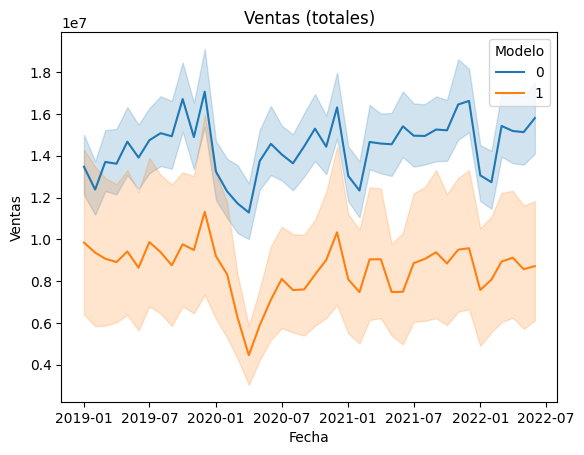

In [105]:
sns.lineplot(x='Fecha', y='Ventas', hue='Modelo', data=ven_mod_t)
plt.title('Ventas (totales)')
plt.show()

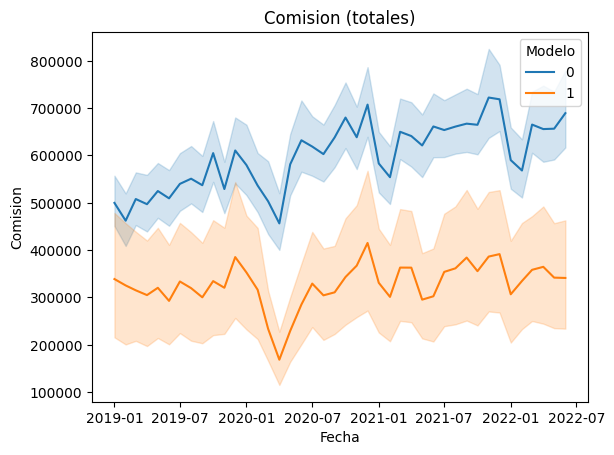

In [106]:
sns.lineplot(x='Fecha', y='Comision', hue='Modelo', data=ven_mod_t)
plt.title('Comision (totales)')
plt.show()

In [107]:
ven_mod_t_pos = ven_mod_t[ven_mod_t['Ventas'] > 0].copy()

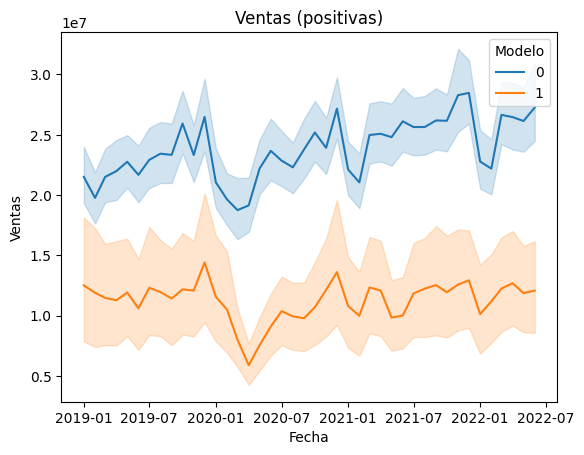

In [108]:
sns.lineplot(x='Fecha', y='Ventas', hue='Modelo', data=ven_mod_t_pos)
plt.title('Ventas (positivas)')
plt.show()

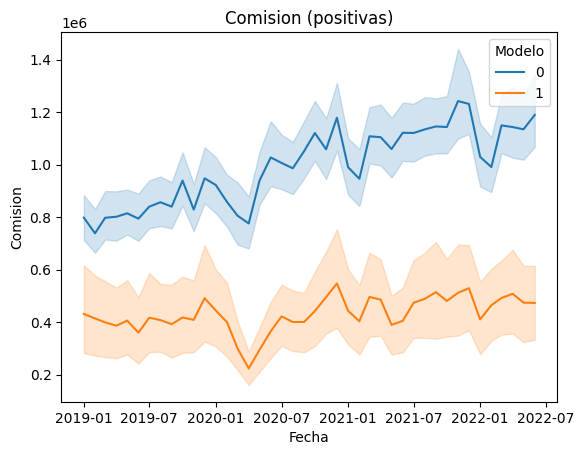

In [109]:
sns.lineplot(x='Fecha', y='Comision', hue='Modelo', data=ven_mod_t_pos)
plt.title('Comision (positivas)')
plt.show()

## Modelos y Subrubros vs. Tiempo

Visualizamos la diferencia entre Modelo y no-Modelo dentro de cada subrubro.

**Observaciones (ventas totales):**
- Los valores de venta en Modelos son menores en todos los Subrubros, con la excepción de tres: "Góndola", "Comb." y "Comb. Ley".
- En los subrubros "Vehículos", "Farmacia" y "Supermercado" los valores de ventas de modelo parecen ser despreciables en comparación con no-Modelo. Tienen valores muy bajos y con muy poca variablidad.
- "Mantenimiento" no parece tener muchos valores Modelo, se podría descartar.

**Observaciones (ventas postivias):**
- Los valores de venta en Modelos son menores en todos los Subrubros, con la excepción de tres: "Góndola" y "Comb.". Ahora "Comb. Ley" se pusieron cabeza a cabeza.
- Se repite lo de "Vehículos", "Farmacia" y "Supermercado".
- "Mantenimiento" no muestra ningún modelo: no hay modelos con ventas positivas en esta categoría

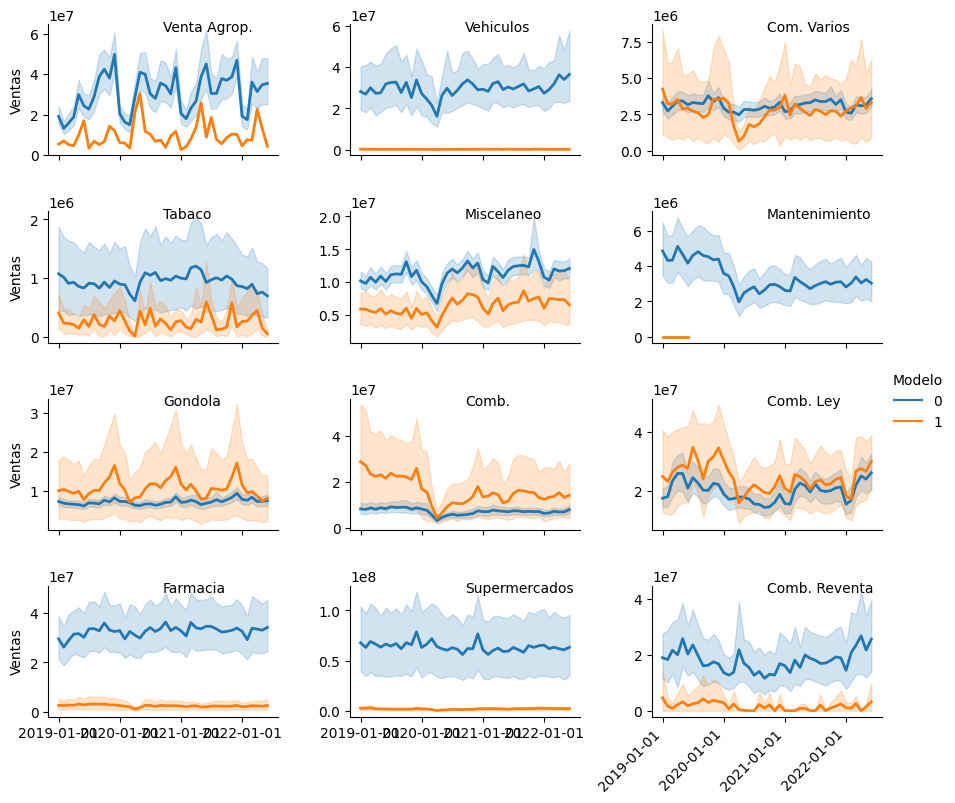

In [110]:
g = sns.relplot(
    data=ventas_fisc,
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

plt.show()

In [111]:
ven_modsub_t_pos = ventas_fisc[ventas_fisc['Ventas'] > 0].copy()

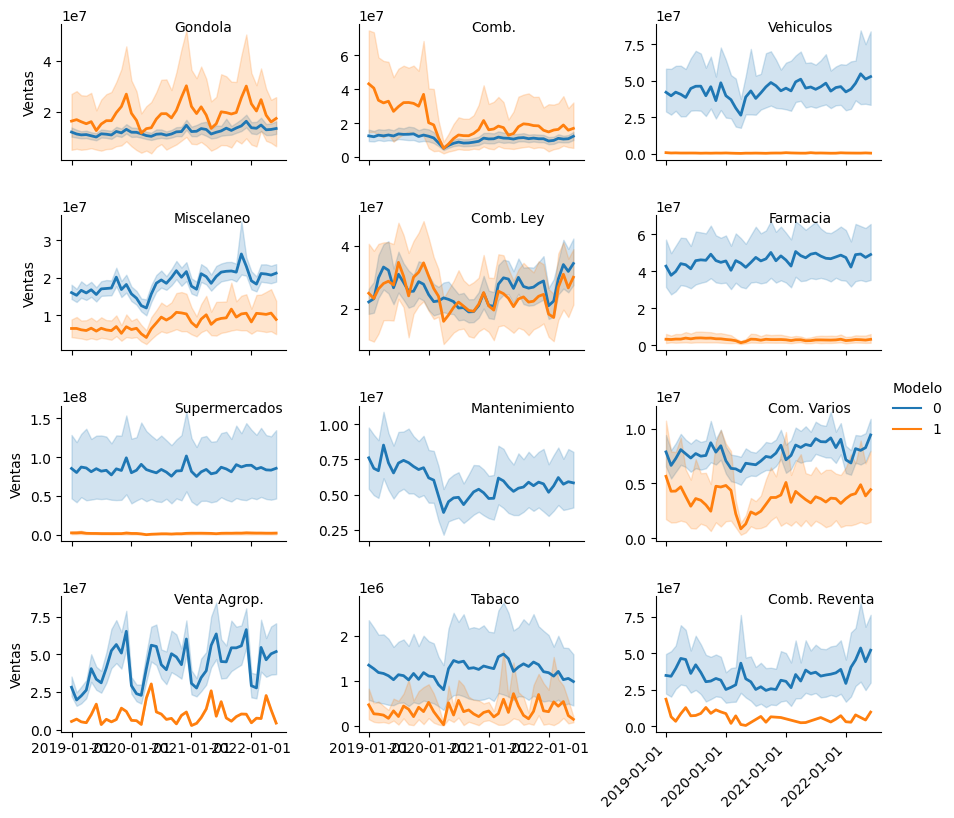

In [112]:
g = sns.relplot(
    data=ven_modsub_t_pos,
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

plt.show()

## Descartamos el subrubro `Mantenimiento`
Eliminamos el subrubro "Mantenimiento" porque hay un solo vendedor modelo, con valores nulos en los primeros meses de la serie (que luego desaparece por completo del dataset)

In [113]:
ventas_sub11 = ventas_fisc[ventas_fisc['Subrubro'] != 'Mantenimiento'].copy()
ventas_sub11.to_csv('../data/interim/tp2_ventas_sub11.csv', index=False)
print(ventas_sub11.shape)

(370580, 8)


---
# Generación de un nuevo dataset: de transacciones a vendedores <span style="color:magenta">**(Paso 8)**</span>

In [306]:
if 'ventas_sub11' not in locals():
    # Para que las funciones se actualicen sin tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_sub11 = pd.read_csv('../data/interim/tp2_ventas_sub11.csv')

ventas_sub11['Fecha'] = ventas_sub11['Fecha'].astype('datetime64[ns]')
ventas_sub11

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,ID,Omega,Subrubro,Fecha,Deposito,Ventas,Comision,Modelo
0,2133,1,Venta Agrop.,2019-01-01,7,-1.116697e+07,-2.233394e+05,0
1,1172,1,Venta Agrop.,2019-01-01,7,-5.494877e+06,-1.318771e+05,0
2,2589,1,Vehiculos,2019-01-01,47,-2.331939e+06,-9.327756e+04,0
3,1907,1,Venta Agrop.,2019-01-01,5,-1.131988e+06,-2.263974e+04,0
4,1478,1,Venta Agrop.,2019-01-01,7,-4.177637e+05,-1.002633e+04,0
...,...,...,...,...,...,...,...,...
370575,815,1,Supermercados,2022-06-01,8,1.567422e+09,7.837112e+07,0
370576,1098,1,Supermercados,2022-06-01,130,1.732460e+09,8.662302e+07,0
370577,1091,1,Supermercados,2022-06-01,130,2.240194e+09,1.120097e+08,0
370578,2862,1,Venta Agrop.,2022-06-01,5,2.631098e+09,7.893293e+07,0


## Agregado
Para cada combinación posible de `Subrubro`, `ID` y `Fecha`, vamos a:
* Sumar todos los valores de `Ventas`.
* Sumar todos los valores de `Comision`.
* Mantener los valores de `Modelo` y de `Omega`.

Al hacer esto, se agregan en una única fila todas las observaciones que pertenezcan a un mismo vendedor en una dada fecha bajo un cierto subrubro, más allá del depósito desde el que se realiza la venta.

In [307]:
agregado = ventas_sub11.groupby(['Subrubro', 'ID', 'Fecha']).agg({
    'Omega': 'min',
    'Ventas': 'sum',
    'Comision': 'sum',
    'Modelo': 'min'
}).reset_index()
agregado

,Subrubro,ID,Fecha,Omega,Ventas,Comision,Modelo
0,Com. Varios,5,2020-04-01,1,482513.902789,26538.266955,0
1,Com. Varios,5,2020-06-01,1,0.000000,0.000000,0
2,Com. Varios,5,2020-07-01,1,203569.512873,11196.335289,0
3,Com. Varios,5,2020-08-01,1,699932.970302,38496.303956,0
4,Com. Varios,5,2020-09-01,1,367710.933143,20224.112762,0
...,...,...,...,...,...,...,...
220242,Venta Agrop.,3122,2022-06-01,1,0.000000,0.000000,0
220243,Venta Agrop.,3137,2022-03-01,1,0.000000,0.000000,0
220244,Venta Agrop.,3137,2022-04-01,1,0.000000,0.000000,0
220245,Venta Agrop.,3137,2022-05-01,1,0.000000,0.000000,0


## Vendedores siempre nulos

Existe la posibilidad de que algunos vendedores tengan siempre ventas nulas dentro de un mismo subrubro. Como no aportan información, nos deshacemos de estos registros. En efecto había 34650 registros que cumplían esta condición.

In [308]:
agregado_no_nulo = agregado.groupby(['Subrubro', 'ID']).filter(lambda x: (x['Ventas'] != 0).any()).copy()
agregado_no_nulo

,Subrubro,ID,Fecha,Omega,Ventas,Comision,Modelo
0,Com. Varios,5,2020-04-01,1,482513.902789,26538.266955,0
1,Com. Varios,5,2020-06-01,1,0.000000,0.000000,0
2,Com. Varios,5,2020-07-01,1,203569.512873,11196.335289,0
3,Com. Varios,5,2020-08-01,1,699932.970302,38496.303956,0
4,Com. Varios,5,2020-09-01,1,367710.933143,20224.112762,0
...,...,...,...,...,...,...,...
220238,Venta Agrop.,3122,2022-02-01,1,0.000000,0.000000,0
220239,Venta Agrop.,3122,2022-03-01,1,0.000000,0.000000,0
220240,Venta Agrop.,3122,2022-04-01,1,0.000000,0.000000,0
220241,Venta Agrop.,3122,2022-05-01,1,0.000000,0.000000,0


## 42 registros por caso

Deberíamos tener 42 observaciones por par ID/Subrubro, pero se ve al comienzo del dataframe anterior que falta, por ejemplo, el 5 del 2020 al vendedor 5 en "Com Varios". Esto pasa en varios casos: a veces hay meses faltantes. Debemos imputar esos meses con valor 0 en ventas y comisión (esto es particularmente importante si luego vamos a hacer diferencias, por ej. para que no se encuentre con un vacío o que me opere contra un mes que en realidad no es el anterior).

In [309]:
promedio_observaciones = agregado_no_nulo.groupby(['Subrubro', 'ID']).size().mean()

# Mostrar el promedio de observaciones por combinación de ID y Subrubro
print(promedio_observaciones)

39.68291639940133


Antes de proceder a rellenar los casos vacíos con valores cero, vamos a crear una variable que nos permita en el fututo distinguir los valores originales de los imputados.

In [310]:
agregado_no_nulo['Dato_original'] = 1

In [311]:
# Contar las observaciones por combinación de ID y Subrubro
conteo_combinaciones = agregado_no_nulo.groupby(['Subrubro', 'ID']).size().reset_index(name='Conteo')

# Filtrar las combinaciones con menos de 42 observaciones
combinaciones_faltantes = conteo_combinaciones[conteo_combinaciones['Conteo'] < 42]

# Lista para almacenar las observaciones faltantes
observaciones_faltantes = []

# Iterar sobre las combinaciones faltantes
for _, combinacion in combinaciones_faltantes.iterrows():
    id_val = combinacion['ID']
    subrubro_val = combinacion['Subrubro']
    
    # Obtener fechas existentes y fechas faltantes
    fechas_existentes = agregado_no_nulo[(agregado_no_nulo['ID'] == id_val) & (agregado_no_nulo['Subrubro'] == subrubro_val)]['Fecha']
    fechas_faltantes = set(agregado_no_nulo['Fecha'].unique()) - set(fechas_existentes)
    
    # Agregar observaciones faltantes al DataFrame
    for fecha_faltante in fechas_faltantes:
        observacion = {
            'ID': id_val,
            'Subrubro': subrubro_val,
            'Fecha': fecha_faltante,
            'Ventas': 0,
            'Comision': 0,
        }
        observaciones_faltantes.append(observacion)

# Crear DataFrame con las observaciones faltantes
df_observaciones_faltantes = pd.DataFrame(observaciones_faltantes)

# Agregar observaciones faltantes al DataFrame agregado_no_nulo
agregado_limpio = pd.concat([agregado_no_nulo, df_observaciones_faltantes], ignore_index=True)

# Mostrar el nuevo DataFrame con las observaciones faltantes agregadas
agregado_limpio

,Subrubro,ID,Fecha,Omega,Ventas,Comision,Modelo,Dato_original
0,Com. Varios,5,2020-04-01,1.0,482513.902789,26538.266955,0.0,1.0
1,Com. Varios,5,2020-06-01,1.0,0.000000,0.000000,0.0,1.0
2,Com. Varios,5,2020-07-01,1.0,203569.512873,11196.335289,0.0,1.0
3,Com. Varios,5,2020-08-01,1.0,699932.970302,38496.303956,0.0,1.0
4,Com. Varios,5,2020-09-01,1.0,367710.933143,20224.112762,0.0,1.0
...,...,...,...,...,...,...,...,...
196429,Venta Agrop.,3122,2021-04-01,NaN,0.000000,0.000000,NaN,NaN
196430,Venta Agrop.,3122,2019-01-01,NaN,0.000000,0.000000,NaN,NaN
196431,Venta Agrop.,3122,2019-04-01,NaN,0.000000,0.000000,NaN,NaN
196432,Venta Agrop.,3122,2020-10-01,NaN,0.000000,0.000000,NaN,NaN


In [312]:
# Imputo los valores Omega y Modelo asociados a los nuevos meses adicionados. Es más eficiente agregarlo en una celda aparte y no en el for (antes demoraba 9 minutos, ahora 1).
agregado_limpio['Omega'] = agregado_limpio.groupby(['ID', 'Subrubro'])['Omega'].transform('max')
agregado_limpio['Modelo'] = agregado_limpio.groupby(['ID', 'Subrubro'])['Modelo'].transform('max')

# Relleno los valores nulos de Dato_original con 0.
agregado_limpio['Dato_original'] = agregado_limpio['Dato_original'].fillna(0)

agregado_limpio

,Subrubro,ID,Fecha,Omega,Ventas,Comision,Modelo,Dato_original
0,Com. Varios,5,2020-04-01,1.0,482513.902789,26538.266955,0.0,1.0
1,Com. Varios,5,2020-06-01,1.0,0.000000,0.000000,0.0,1.0
2,Com. Varios,5,2020-07-01,1.0,203569.512873,11196.335289,0.0,1.0
3,Com. Varios,5,2020-08-01,1.0,699932.970302,38496.303956,0.0,1.0
4,Com. Varios,5,2020-09-01,1.0,367710.933143,20224.112762,0.0,1.0
...,...,...,...,...,...,...,...,...
196429,Venta Agrop.,3122,2021-04-01,1.0,0.000000,0.000000,0.0,0.0
196430,Venta Agrop.,3122,2019-01-01,1.0,0.000000,0.000000,0.0,0.0
196431,Venta Agrop.,3122,2019-04-01,1.0,0.000000,0.000000,0.0,0.0
196432,Venta Agrop.,3122,2020-10-01,1.0,0.000000,0.000000,0.0,0.0


In [313]:
agregado_limpio.dtypes

Subrubro                 object
ID                        int64
Fecha            datetime64[ns]
Omega                   float64
Ventas                  float64
Comision                float64
Modelo                  float64
Dato_original           float64
dtype: object

In [314]:
# Convertir las columnas 'Omega', 'Modelo' y 'Dato_original' a tipo int64
agregado_limpio['Omega'] = agregado_limpio['Omega'].astype('int64')
agregado_limpio['Modelo'] = agregado_limpio['Modelo'].astype('int64')
agregado_limpio['Dato_original'] = agregado_limpio['Dato_original'].astype('int64')

In [315]:
agregado_limpio

,Subrubro,ID,Fecha,Omega,Ventas,Comision,Modelo,Dato_original
0,Com. Varios,5,2020-04-01,1,482513.902789,26538.266955,0,1
1,Com. Varios,5,2020-06-01,1,0.000000,0.000000,0,1
2,Com. Varios,5,2020-07-01,1,203569.512873,11196.335289,0,1
3,Com. Varios,5,2020-08-01,1,699932.970302,38496.303956,0,1
4,Com. Varios,5,2020-09-01,1,367710.933143,20224.112762,0,1
...,...,...,...,...,...,...,...,...
196429,Venta Agrop.,3122,2021-04-01,1,0.000000,0.000000,0,0
196430,Venta Agrop.,3122,2019-01-01,1,0.000000,0.000000,0,0
196431,Venta Agrop.,3122,2019-04-01,1,0.000000,0.000000,0,0
196432,Venta Agrop.,3122,2020-10-01,1,0.000000,0.000000,0,0


In [316]:
promedio_observaciones = agregado_limpio.groupby(['Subrubro', 'ID']).size().mean()

# Mostrar el promedio de observaciones por combinación de ID y Subrubro
print(promedio_observaciones)

42.0


In [317]:
registros_vendedores_abs = agregado_limpio.sort_values(['Fecha', 'Subrubro', 'ID']) # Dejar que primero esté Fecha. Sirve para el pivoteo de la próxima sección.
registros_vendedores_abs.to_csv('../data/interim/tp2_registros_vendedores_abs.csv', index=False)

## Incrementos: valores relativos

In [318]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones propias
from utils_limpieza import * 

registros_vendedores_abs = pd.read_csv('../data/interim/tp2_registros_vendedores_abs.csv')
registros_vendedores_abs['Fecha'] = registros_vendedores_abs['Fecha'].astype('datetime64[ns]')
registros_vendedores_rel = registros_vendedores_abs.copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [319]:
crear_diferencia_porcentual(registros_vendedores_rel, 'Ventas', 12)
crear_diferencia_porcentual(registros_vendedores_rel, 'Comision', 12)
crear_diferencia_porcentual(registros_vendedores_rel, 'Ventas', 4)
crear_diferencia_porcentual(registros_vendedores_rel, 'Comision', 4)
registros_vendedores_rel[(registros_vendedores_rel['ID'] == 5) & (registros_vendedores_rel['Subrubro'] == 'Com. Varios')]

,Subrubro,ID,Fecha,Omega,Ventas,Comision,Modelo,Dato_original,Y_pct_Ventas,Y_pct_Comision,F_pct_Ventas,F_pct_Comision
0,Com. Varios,5,2019-01-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
4677,Com. Varios,5,2019-02-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
9354,Com. Varios,5,2019-03-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
14031,Com. Varios,5,2019-04-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
18708,Com. Varios,5,2019-05-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
23385,Com. Varios,5,2019-06-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
28062,Com. Varios,5,2019-07-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
32739,Com. Varios,5,2019-08-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
37416,Com. Varios,5,2019-09-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN
42093,Com. Varios,5,2019-10-01,1,0.000000e+00,0.000000,0,0,NaN,NaN,NaN,NaN


In [320]:
pivotear = registros_vendedores_rel.copy()

In [321]:
# Extraer el mes y el año de la columna "Fecha"
pivotear["Fecha"] = pd.to_datetime(pivotear["Fecha"])
pivotear["Month"] = pivotear["Fecha"].dt.month
pivotear["Year"] = pivotear["Fecha"].dt.year

# Convertir "Month" a string con formato de dos cifras
pivotear["Month"] = pivotear["Month"].apply(lambda x: str(x).zfill(2))

# Convertir "Year" a string y quedarse con los últimos 2 dígitos
pivotear["Year"] = pivotear["Year"].apply(lambda x: str(x)[-2:])

# Crear la variable "Fecha2" que concatena "Year" y "Month"
pivotear["Fecha2"] = pivotear["Year"] + pivotear["Month"]

# Eliminar columnas
pivotear.drop(columns=['Fecha','Ventas','Comision','Dato_original','Month','Year'], inplace=True)

# Renombrar la columna "Fecha2" a "Fecha"
pivotear.rename(columns={'Fecha2': 'Fecha', 'Y_pct_Ventas': 'Y_pct_Ven', 'Y_pct_Comision': 'Y_pct_Com', 'F_pct_Ventas': 'F_pct_Ven', 'F_pct_Comision': 'F_pct_Com'}, inplace=True)

pivotear

,Subrubro,ID,Omega,Modelo,Y_pct_Ven,Y_pct_Com,F_pct_Ven,F_pct_Com,Fecha
0,Com. Varios,5,1,0,NaN,NaN,NaN,NaN,1901
1,Com. Varios,20,1,0,NaN,NaN,NaN,NaN,1901
2,Com. Varios,23,1,0,NaN,NaN,NaN,NaN,1901
3,Com. Varios,34,1,0,NaN,NaN,NaN,NaN,1901
4,Com. Varios,42,1,0,NaN,NaN,NaN,NaN,1901
...,...,...,...,...,...,...,...,...,...
196429,Venta Agrop.,3030,1,0,-0.970383,-0.970383,-0.793634,-0.793634,2206
196430,Venta Agrop.,3048,1,0,0.288031,0.288031,-0.025383,-0.025383,2206
196431,Venta Agrop.,3063,1,0,76.690935,63.742633,21.029548,21.029522,2206
196432,Venta Agrop.,3072,1,0,inf,inf,inf,inf,2206


In [322]:
# Realizar el pivoteo y la agrupación
pivot_df = pivotear.pivot_table(index=["ID",'Subrubro','Omega','Modelo'], columns=['Fecha'], values=['Y_pct_Ven', 'Y_pct_Com', 'F_pct_Ven', 'F_pct_Com'])

# Generar los nombres de las columnas finales
columns = [f"{col[0]}_{col[1]}" for col in pivot_df.columns]

# Asignar los nuevos nombres de columnas
pivot_df.columns = columns

# Restablecer el índice para que "ID" vuelva a ser una columna
pivot_df = pivot_df.reset_index()

In [323]:
pivot_df

,ID,Subrubro,Omega,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,...,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
0,0,Miscelaneo,1,0,-1.000000,-0.388794,inf,-1.000000,NaN,-1.000000,...,inf,NaN,-0.919475,-0.450937,inf,-1.000000,inf,inf,NaN,inf
1,1,Miscelaneo,1,0,0.559349,0.591999,0.011470,-0.267213,-0.441588,-0.430018,...,0.353202,0.299397,0.244381,-0.052702,-0.021221,0.453017,0.027594,0.183219,0.475884,0.351416
2,2,Miscelaneo,1,0,0.012719,-0.010125,0.325712,0.167671,-0.260562,0.173718,...,-0.250917,-0.102872,-0.431158,-0.332711,-0.332390,0.737398,-0.645376,-0.433219,-0.221058,-0.274480
3,4,Gondola,1,0,0.193896,0.072714,-0.055670,0.027243,-0.173982,0.008415,...,0.168828,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606
4,5,Com. Varios,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.000000,inf,NaN,NaN,-1.000000,inf,1.093143,-1.000000,-1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4632,3118,Gondola,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.116964,-0.736126,-0.145892,0.011339
4633,3119,Miscelaneo,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4634,3122,Venta Agrop.,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4635,3123,Miscelaneo,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [324]:
pivot_df.to_csv('../data/interim/tp2_vendedores_vector.csv', index=False)